In [1]:
#这个脚本用于将gromacs输出的pdb轨迹文件转换成convert_dataset.py读入的格式
import argparse
import pandas as pd

parser = argparse.ArgumentParser('Preprocessing: Generate pdb file from xtc file')
parser.add_argument('--MDfolder', type=str, default="data/pdb/",
                    help='folder of pdb MD')
parser.add_argument('--interval', type=int, default="3",        #每隔多少个residue进行输出一次
                    help='select residues according to interval provided')

parser.add_argument('--max_model_num', type=int, default="5000",  #指定输出的frame个数   
                    help='maxmum model number to output')

parser.add_argument('--pdb_num', type=int, default="5",     #需要转换的PDB文件的个数
                    help='maxmum model number to output')

args = parser.parse_args(args=[])

def read_pdb_write(read_filename, write_filename, comparison_filename,interval,max_model_num):
    
    f1=open(read_filename,'r')     # 读入提供的文件
    f2=open(write_filename,'w')     #写入新的符合格式的文件
    f3=open(comparison_filename,'w')  #产生残基对照表
    count=0   #记录读取了几行，当其等于给定的interval时，就选取这一行输出，然后将其清零
    model_num=0    # 记录第几个model
    atom_num=0     #记录在一个model中选取的第几个残基或原子
    residue_num=0  #记录被写入文件的残基本来的序号
    lines = f1.readlines()
    
    for line in lines:
        line = line.strip()
        words = line.split()
        
        #print(words[0])
        if(words[0]!="MODEL" and words[0]!="ATOM" and words[0]!="ENDMDL"):
            #print(1)
            continue
        elif(words[0]=="MODEL"):
            #print(words[1])
            if(int(words[1])>max_model_num):   #指定输出多少个frame
                break
            model_num+=1
            newline=line[0:5]+'     '+str(model_num)+'\n'
            f2.writelines(newline)
            count=0
            atom_num=0
           
            continue
        elif(words[0]=="ENDMDL"):
            #print(2)
            line+='\n'
            f2.writelines(line)
            count=0
            atom_num=0
           
            continue
        elif(words[0]=="ATOM"):
            #print(3)
            
            count+=1
            if(count==interval):
                atom_num+=1
                count=0
                if(model_num==max_model_num):
                    f3.writelines(str(atom_num)+'              '+str(words[5])+'\n')
                if(atom_num<10):     #当序号是单数，双数还是三位数时，空格不一样，为保证格式的统一，用条件语句进行区分
                    
                    newline=line[0:4]+'      '+str(atom_num)+line[11:20]+'    '+str(atom_num)+line[26:]+'\n'
                    f2.writelines(newline)
                elif(atom_num>=10 and atom_num<=99):
                    newline=line[0:4]+'     '+str(atom_num)+line[11:20]+'   '+str(atom_num)+line[26:]+'\n'
                    f2.writelines(newline)
                elif(atom_num>=10 and atom_num<=200):
                    newline=line[0:4]+'    '+str(atom_num)+line[11:20]+'  '+str(atom_num)+line[26:]+'\n'
                    f2.writelines(newline)
                elif(atom_num>200):     #不能输出超过150个
                    print('mistake')
                    break             
            else:
                continue
    f1.close()
    f2.close()
    f3.close()

MDfolder = args.MDfolder
interval = args.interval
max_model_num = args.max_model_num   
pdb_num = args.pdb_num  

for i in range(1,pdb_num+1):
    print("Start: "+str(i)+"th PDB")
    read_pdb_write(MDfolder+'protein'+str(i)+'.pdb',MDfolder+'protein_nri'+str(i)+'.pdb',MDfolder+'protein_comparison'+str(i)+'.txt',interval,max_model_num)

print('helloworld')

Start: 1th PDB
Start: 2th PDB
Start: 3th PDB
Start: 4th PDB
Start: 5th PDB
helloworld


In [2]:
import time
import numpy as np
import argparse
from copy import deepcopy
from scipy import interpolate

parser = argparse.ArgumentParser('Preprocessing: Generate training/validation/testing features from pdb')
parser.add_argument('--MDfolder', type=str, default="data/pdb/",
                    help='folder of pdb MD')
parser.add_argument('--pdb-start', type=int, default="1",
                    help='select pdb file window from start, e.g. in tutorial it is ca_1.pdb')
parser.add_argument('--pdb-end', type=int, default="96",
                    help='select pdb file window to end')
parser.add_argument('--num-residues', type=int, default=176,     #文件包含的残基数量，一般要小于100，不然无法计算
                    help='Number of residues of the MD pdb')
parser.add_argument('--feature-size', type=int, default=6,
                    help='The number of features used in study( position (X,Y,Z) + velocity (X,Y,Z) ).')
parser.add_argument('--train-interval', type=int, default=100,  #上图中的interval数值，其和time step的数值乘积应等于文件中包含的frame数量
                    help='intervals in trajectory in training')  #因此如果总的frame是5000，就调整为100，为3000，就调整为60
parser.add_argument('--validate-interval', type=int, default=100, #time step数值是在程序最后设定的，一般默认为50效果就最好了
                    help='intervals in trajectory in validate')
parser.add_argument('--test-interval', type=int, default=100,
                    help='intervals in trajectory in test')
parser.add_argument('--timestep_size', type=int, default=50,
                    help='time step')
parser.add_argument('--experiment_size', type=int, default=5,   #进行的实验重复数量，其对应着提供的PDB文件个数
                    help='experiment_size')
parser.add_argument('--startIndex', type=int, default=1,  
                    help='startIndex')


#args = parser.parse_args() # 在jupyter notebook中需要用下面的形式，即输入一个空的参数列表才可以，这样就只会读入默认参数，不会报错了
args = parser.parse_args(args=[])


def read_feature_file(filename, feature_size=1, gene_size=10, timestep_size=21):
    """
    Read single expriments of all time points
    """
    feature = np.zeros((timestep_size, feature_size, gene_size))

    time_count = -1
    with open(filename) as f:
        lines = f.readlines()
        for line in lines:
            line = line.strip()
            if(time_count >= 0 and time_count < timestep_size):
                words = line.split()
                data_count = 0
                for word in words:
                    feature[time_count, 0, data_count] = word
                    data_count += 1
            time_count += 1
    f.close()
    # Use interpole
    feature = timepoint_sim(feature, 4)
    return feature


def read_feature_Residue_file(filename):
    resdict = {}
    count = 0
    with open(filename) as f:
        lines = f.readlines()
        for line in lines:
            line = line.strip()
            words = line.split(",")
            if count > 0:
                feature = np.zeros((len(words)-1))
                for i in range(len(words)-1):
                    feature[i] = words[i+1]
                resdict[words[0]] = feature
            count = count+1
    return resdict


def read_feature_MD_file(filename, timestep_size, feature_size, num_residues, interval):
    """
    Read single expriments of all time points
    """
    feature = np.zeros((timestep_size, feature_size, num_residues))

    flag = False
    nflag = False
    modelNum = 0
    with open(filename) as f:
        lines = f.readlines()
        for line in lines:
            line = line.strip()
            words = line.split()
            if(line.startswith("MODEL")):
                modelNum = int(words[1])
                if (modelNum % interval == 1):
                    flag = True
                if (modelNum % interval == 2):
                    nflag = True
            elif(line.startswith("ATOM") and words[2] == "CA" and flag):
                numStep = int(modelNum/interval)
                feature[numStep, 0, int(words[5])-1] = float(words[6])
                feature[numStep, 1, int(words[5])-1] = float(words[7])
                feature[numStep, 2, int(words[5])-1] = float(words[8])
            elif(line.startswith("ATOM") and words[2] == "CA" and nflag):
                numStep = int(modelNum/interval)
                feature[numStep, 3, int(
                    words[5])-1] = float(words[6])-feature[numStep, 0, int(words[5])-1]
                feature[numStep, 4, int(
                    words[5])-1] = float(words[7])-feature[numStep, 1, int(words[5])-1]
                feature[numStep, 5, int(
                    words[5])-1] = float(words[8])-feature[numStep, 2, int(words[5])-1]
            elif(line.startswith("ENDMDL") and flag):
                flag = False
            elif(line.startswith("ENDMDL") and nflag):
                nflag = False
    f.close()
    return feature


def read_feature_MD_file_slidingwindow(filename, timestep_size, feature_size, num_residues, interval, window_choose, aa_start, aa_end):
    # read single expriments of all time points
    feature = np.zeros((timestep_size, feature_size, num_residues))

    flag = False
    nflag = False
    modelNum = 0
    with open(filename) as f:
        lines = f.readlines()
        for line in lines:
            line = line.strip()
            words = line.split()
            if(line.startswith("MODEL")):
                modelNum = int(words[1])
                if (modelNum % interval == window_choose):
                    flag = True
                if (modelNum % interval == (window_choose+1)):
                    nflag = True
            elif(line.startswith("ATOM") and words[2] == "CA" and int(words[4]) >= aa_start and int(words[4]) <= aa_end and flag):
                numStep = int(modelNum/interval)
                feature[numStep, 0, int(words[4])-aa_start] = float(words[5])
                feature[numStep, 1, int(words[4])-aa_start] = float(words[6])
                feature[numStep, 2, int(words[4])-aa_start] = float(words[7])
            elif(line.startswith("ATOM") and words[2] == "CA" and int(words[4]) >= aa_start and int(words[4]) <= aa_end and nflag):
                numStep = int(modelNum/interval)
                feature[numStep, 3, int(
                    words[4])-aa_start] = float(words[5])-feature[numStep, 0, int(words[4])-aa_start]
                feature[numStep, 4, int(
                    words[4])-aa_start] = float(words[6])-feature[numStep, 1, int(words[4])-aa_start]
                feature[numStep, 5, int(
                    words[4])-aa_start] = float(words[7])-feature[numStep, 2, int(words[4])-aa_start]
            elif(line.startswith("ENDMDL") and flag):
                flag = False
            elif(line.startswith("ENDMDL") and nflag):
                nflag = False
    f.close()
    # print(feature.shape)
    return feature


def read_feature_MD_file_resi(filename, resDict, feature_size, num_residues, timestep_size, interval):
    # read single expriments of all time points
    feature = np.zeros((timestep_size, feature_size, num_residues))

    flag = False
    nflag = False
    modelNum = 0
    with open(filename) as f:
        lines = f.readlines()
        for line in lines:
            line = line.strip()
            words = line.split()
            if(line.startswith("MODEL")):
                modelNum = int(words[1])
                if (modelNum % interval == 1):
                    flag = True
                if (modelNum % interval == 2):
                    nflag = True
            elif(line.startswith("ATOM") and words[2] == "CA" and flag):
                numStep = int(modelNum/interval)
                feature[numStep, 0, int(words[4])-1] = float(words[5])
                feature[numStep, 1, int(words[4])-1] = float(words[6])
                feature[numStep, 2, int(words[4])-1] = float(words[7])
                featureResi = resDict[words[3]]
                for i in range(6, 6+featureResi.shape[0]):
                    feature[numStep, i, int(words[4])-1] = featureResi[i-6]

            elif(line.startswith("ATOM") and words[2] == "CA" and nflag):
                numStep = int(modelNum/interval)
                feature[numStep, 3, int(
                    words[4])-1] = float(words[5])-feature[numStep, 0, int(words[4])-1]
                feature[numStep, 4, int(
                    words[4])-1] = float(words[6])-feature[numStep, 1, int(words[4])-1]
                feature[numStep, 5, int(
                    words[4])-1] = float(words[7])-feature[numStep, 2, int(words[4])-1]
            elif(line.startswith("ENDMDL") and flag):
                flag = False
            elif(line.startswith("ENDMDL") and nflag):
                nflag = False
    f.close()
    return feature


def read_edge_file(filename, gene_size):
    edges = np.zeros((gene_size, gene_size))
    count = 0
    with open(filename) as f:
        lines = f.readlines()
        for line in lines:
            line = line.strip()
            words = line.split()
            data_count = 0
            for word in words:
                edges[count, data_count] = word
                data_count += 1
            count += 1
    f.close()
    return edges


def convert_dataset(feature_filename, edge_filename, experiment_size=5):
    features = list()

    edges = np.zeros((experiment_size, experiment_size))

    for i in range(1, experiment_size+1):
        features.append(read_feature_file(feature_filename+"_"+str(i)+".txt"))

    count = 0
    with open(edge_filename) as f:
        lines = f.readlines()
        for line in lines:
            line = line.strip()
            words = line.split()
            data_count = 0
            for word in words:
                edges[count, data_count] = word
                data_count += 1
            count += 1
    f.close()

    features = np.stack(features, axis=0)
    edges = np.tile(edges, (features.shape[0], 1)).reshape(
        features.shape[0], features.shape[3], features.shape[3])
    return features, edges


def convert_dataset_sim(feature_filename, edge_filename, experiment_size=5, gene_size=5, sim_size=50000):
    features = list()

    edges = np.zeros((gene_size, gene_size))

    for i in range(1, experiment_size+1):
        features.append(read_feature_file(
            feature_filename+"_"+str(i)+".txt"), gene_size=5)

    count = 0
    with open(edge_filename) as f:
        lines = f.readlines()
        for line in lines:
            line = line.strip()
            words = line.split()
            data_count = 0
            for word in words:
                edges[count, data_count] = word
                data_count += 1
            count += 1
    f.close()

    features = np.stack(features, axis=0)

    features_out = np.zeros(
        (sim_size, features.shape[1], features.shape[2], features.shape[3]))
    edges_out = np.zeros((sim_size, gene_size, gene_size))

    for i in range(sim_size):
        index = np.random.permutation(np.arange(experiment_size))
        num = np.random.permutation(np.arange(experiment_size))[0]
        features_out[i, :, :, :] = features[num, :, :, :][:, :, index]
        edges_out[i, :, :] = edges[index, :][:, index]

    # Add noise
    features_out = features_out + \
        np.random.randn(
            sim_size, features.shape[1], features.shape[2], features.shape[3])
    return features_out, edges_out


def convert_dataset_md(feature_filename, startIndex, experiment_size, timestep_size, feature_size, num_residues, interval):
    features = list()
    edges = list()

    for i in range(startIndex, experiment_size+1):
        print("Start: "+str(i)+"th PDB")
        features.append(read_feature_MD_file(feature_filename+"smd"+str(i) +
                                             ".pdb", timestep_size, feature_size, num_residues, interval))
        edges.append(np.zeros((num_residues, num_residues)))

    features = np.stack(features, axis=0)
    edges = np.stack(edges, axis=0)

    return features, edges


def convert_dataset_md_single(MDfolder, startIndex, experiment_size, timestep_size, feature_size, num_residues, interval, pdb_start, pdb_end, aa_start, aa_end):
    """
    Convert in single md file in single skeleton
    """
    features = list()
    edges = list()

    for i in range(startIndex, experiment_size+1):
        print("Start: "+str(i)+"th PDB")
        for j in range(pdb_start, pdb_end+1):
            # print(str(i)+" "+str(j))
            features.append(read_feature_MD_file_slidingwindow(MDfolder+"protein_nri"+str(
                i)+".pdb", timestep_size, feature_size, num_residues, interval, j, aa_start, aa_end))
            edges.append(np.zeros((num_residues, num_residues)))
    print("***")
    print(len(features))
    print("###")
    features = np.stack(features, axis=0)
    edges = np.stack(edges, axis=0)

    return features, edges


def timepoint_sim(feature, fold):
    # hard code now,fold=4
    # feature_shape: [timestep, feature_size, gene]
    step = 1/fold
    timestep = feature.shape[0]
    genes = feature.shape[2]
    x = np.arange(timestep)
    xnew = np.arange(0, (timestep-1)+step, step)
    feature_out = np.zeros((xnew.shape[0], 1, genes))
    for gene in range(genes):
        y = feature[:, 0, gene]
        tck = interpolate.splrep(x, y, s=0)
        ynew = interpolate.splev(xnew, tck, der=0)
        feature_out[:, 0, gene] = ynew
    return feature_out


MDfolder = args.MDfolder
feature_size = args.feature_size
num_residues = args.num_residues
pdb_start = args.pdb_start
pdb_end = args.pdb_end
train_interval = args.train_interval
validate_interval = args.validate_interval
test_interval = args.test_interval
startIndex = args.startIndex
experiment_size = args.experiment_size
timestep_size = args.timestep_size
# Generate training/validating/testing
print("Generate Train")
features, edges = convert_dataset_md_single(MDfolder, startIndex, experiment_size, timestep_size,
                                            feature_size=feature_size, num_residues=num_residues, interval=train_interval, pdb_start=pdb_start, pdb_end=pdb_end, aa_start=1, aa_end=num_residues)

np.save('data/features.npy', features)
np.save('data/edges.npy', edges)


print("Generate Valid")
features_valid, edges_valid = convert_dataset_md_single(MDfolder, startIndex, experiment_size, timestep_size,
                                                        feature_size=feature_size, num_residues=num_residues, interval=validate_interval, pdb_start=pdb_start, pdb_end=pdb_end, aa_start=1, aa_end=num_residues)

np.save('data/features_valid.npy', features_valid)
np.save('data/edges_valid.npy', edges_valid)


print("Generate Test")
features_test, edges_test = convert_dataset_md_single(MDfolder, startIndex, experiment_size, timestep_size,
                                                      feature_size=feature_size, num_residues=num_residues, interval=test_interval, pdb_start=pdb_start, pdb_end=pdb_end, aa_start=1, aa_end=num_residues)
np.save('data/features_test.npy', features_test)
np.save('data/edges_test.npy', edges_test)

Generate Train
Start: 1th PDB
Start: 2th PDB
Start: 3th PDB
Start: 4th PDB
Start: 5th PDB
***
480
###
Generate Valid
Start: 1th PDB
Start: 2th PDB
Start: 3th PDB
Start: 4th PDB
Start: 5th PDB
***
480
###
Generate Test
Start: 1th PDB
Start: 2th PDB
Start: 3th PDB
Start: 4th PDB
Start: 5th PDB
***
480
###


# reset

In [10]:
import torch 
import gc

torch.cuda.empty_cache()
gc.collect()
print(f"Allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
print(f"Reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

Allocated memory: 0.04 GB
Reserved memory: 23.17 GB


In [12]:
import numpy as np 
np.float = float

In [ ]:
import time
import argparse
import pickle
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:Ture'
import datetime
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
from utils import *
from modules import *
parser = argparse.ArgumentParser(
    'Neral relational inference for molecular dynamics simulations')
parser.add_argument('--num-residues', type=int, default=176,        #残基个数，这里要根据实际情况进行修改
                    help='Number of residues of the PDB.')
parser.add_argument('--save-folder', type=str, default='logs',
                    help='Where to save the trained model, leave empty to not save anything.')
parser.add_argument('--load-folder', type=str, default='',
                    help='Where to load the trained model if finetunning. ' +
                         'Leave empty to train from scratch')
parser.add_argument('--edge-types', type=int, default=4,
                    help='The number of edge types to infer.')
parser.add_argument('--dims', type=int, default=6,
                    help='The number of input dimensions used in study( position (X,Y,Z) + velocity (X,Y,Z) ). ')
parser.add_argument('--timesteps', type=int, default=50,
                    help='The number of time steps per sample. Actually is 50')
parser.add_argument('--prediction-steps', type=int, default=1, metavar='N',
                    help='Num steps to predict before re-using teacher forcing.')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='Disables CUDA training.')
parser.add_argument('--seed', type=int, default=42, help='Random seed.')
parser.add_argument('--epochs', type=int, default=500,
                    help='Number of epochs to train.')
parser.add_argument('--batch-size', type=int, default=1,
                    help='Number of samples per batch.')
parser.add_argument('--lr', type=float, default=0.0005,
                    help='Initial learning rate.')
parser.add_argument('--encoder-hidden', type=int, default=256,
                    help='Number of hidden units in encoder.')
parser.add_argument('--decoder-hidden', type=int, default=256,
                    help='Number of hidden units in decoder.')
parser.add_argument('--temp', type=float, default=0.5,
                    help='Temperature for Gumbel softmax.')
parser.add_argument('--encoder', type=str, default='mlp',
                    help='Type of path encoder model (mlp or cnn).')
parser.add_argument('--decoder', type=str, default='rnn',
                    help='Type of decoder model (mlp, rnn, or sim).')
parser.add_argument('--no-factor', action='store_true', default=False,
                    help='Disables factor graph model.')
parser.add_argument('--encoder-dropout', type=float, default=0.0,
                    help='Dropout rate (1 - keep probability) in encoder.')
parser.add_argument('--decoder-dropout', type=float, default=0.0,
                    help='Dropout rate (1 - keep probability) in decoder.')
parser.add_argument('--lr-decay', type=int, default=200,
                    help='After how epochs to decay LR by a factor of gamma.')
parser.add_argument('--gamma', type=float, default=0.5,
                    help='LR decay factor.')
parser.add_argument('--skip-first', action='store_true', default=True,
                    help='Skip first edge type in decoder, i.e. it represents no-edge.')
parser.add_argument('--var', type=float, default=5e-5,
                    help='Output variance.')
parser.add_argument('--hard', action='store_true', default=True,
                    help='Uses discrete samples in training forward pass.')
parser.add_argument('--prior', action='store_true', default=True,
                    help='Whether to use sparsity prior.')
parser.add_argument('--dynamic-graph', action='store_true', default=True,
                    help='Whether test with dynamically re-computed graph.')
parser.add_argument('--number-expstart', type=int, default=0,
                    help='start number of experiments.')
parser.add_argument('--number-exp', type=int, default=96,      #实验重复个数，这里要根据实际情况进行修改
                    help='number of experiments.')

#args = parser.parse_args()
args = parser.parse_args(args=[])
args.cuda = not args.no_cuda and torch.cuda.is_available()
args.factor = not args.no_factor
# print all arguments
print(args)

np.random.seed(args.seed)
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

if args.dynamic_graph:
    print("Testing with dynamically re-computed graph.")

# Save model and meta-data. Always saves in a new sub-folder.
if args.save_folder:
    exp_counter = 0
    now = datetime.datetime.now()
    timestamp = now.isoformat()
    save_folder = args.save_folder+'/'
    if not os.path.isdir(save_folder):
        os.mkdir(save_folder)
    meta_file = os.path.join(save_folder, 'metadata.pkl')
    encoder_file = os.path.join(save_folder, 'encoder.pt')
    decoder_file = os.path.join(save_folder, 'decoder.pt')

    log_file = os.path.join(save_folder, 'log.txt')
    log = open(log_file, 'w')

    pickle.dump({'args': args}, open(meta_file, "wb"))
else:
    print("WARNING: No save_folder provided!" +
          "Testing (within this script) will throw an error.")
  


# load data
train_loader, valid_loader, test_loader, loc_max, loc_min, vel_max, vel_min = load_dataset_train_valid_test(
    args.batch_size, args.number_exp, args.number_expstart, args.dims)

# Generate off-diagonal interaction graph
off_diag = np.ones([args.num_residues, args.num_residues]
                   ) - np.eye(args.num_residues)

rel_rec = np.array(encode_onehot(np.where(off_diag)[1]), dtype=np.float32)
rel_send = np.array(encode_onehot(np.where(off_diag)[0]), dtype=np.float32)
rel_rec = torch.FloatTensor(rel_rec)
rel_send = torch.FloatTensor(rel_send)

if args.encoder == 'mlp':
    encoder = MLPEncoder(args.timesteps * args.dims, args.encoder_hidden,
                         args.edge_types,
                         args.encoder_dropout, args.factor)
elif args.encoder == 'cnn':
    encoder = CNNEncoder(args.dims, args.encoder_hidden,
                         args.edge_types,
                         args.encoder_dropout, args.factor)

if args.decoder == 'mlp':
    decoder = MLPDecoder(n_in_node=args.dims,
                         edge_types=args.edge_types,
                         msg_hid=args.decoder_hidden,
                         msg_out=args.decoder_hidden,
                         n_hid=args.decoder_hidden,
                         do_prob=args.decoder_dropout,
                         skip_first=args.skip_first)
elif args.decoder == 'rnn':
    decoder = RNNDecoder(n_in_node=args.dims,
                         edge_types=args.edge_types,
                         n_hid=args.decoder_hidden,
                         do_prob=args.decoder_dropout,
                         skip_first=args.skip_first)
elif args.decoder == 'sim':
    decoder = SimulationDecoder(
        loc_max, loc_min, vel_max, vel_min, args.suffix)

if args.load_folder:
    encoder_file = os.path.join(args.load_folder, 'encoder.pt')
    encoder.load_state_dict(torch.load(encoder_file))
    decoder_file = os.path.join(args.load_folder, 'decoder.pt')
    decoder.load_state_dict(torch.load(decoder_file))

    args.save_folder = False

optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()),
                       lr=args.lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=args.lr_decay,
                                gamma=args.gamma)

# Linear indices of an upper triangular mx, used for acc calculation
triu_indices = get_triu_offdiag_indices(args.num_residues)
tril_indices = get_tril_offdiag_indices(args.num_residues)

if args.prior:
    prior = np.array([0.91, 0.03, 0.03, 0.03])  # TODO: hard coded for now
    print("Using prior")
    print(prior)
    log_prior = torch.FloatTensor(np.log(prior))
    log_prior = torch.unsqueeze(log_prior, 0)
    log_prior = torch.unsqueeze(log_prior, 0)
    log_prior = Variable(log_prior)

    if args.cuda:
        log_prior = log_prior.cuda()

if args.cuda:
    encoder.cuda()
    decoder.cuda()
    rel_rec = rel_rec.cuda()
    rel_send = rel_send.cuda()
    triu_indices = triu_indices.cuda()
    tril_indices = tril_indices.cuda()

rel_rec = Variable(rel_rec)
rel_send = Variable(rel_send)


def train(epoch, best_val_loss):
    t = time.time()
    nll_train = []
    acc_train = []
    kl_train = []
    mse_train = []
    edges_train = []
    probs_train = []

    encoder.train()
    decoder.train()

    for batch_idx, (data, relations) in enumerate(train_loader):

        if args.cuda:
            data, relations = data.cuda(), relations.cuda()
        data, relations = Variable(data), Variable(relations)

        optimizer.zero_grad()

        logits = encoder(data, rel_rec, rel_send)
        edges = gumbel_softmax(logits, tau=args.temp, hard=args.hard)
        prob = my_softmax(logits, -1)

        if args.decoder == 'rnn':
            output = decoder(data, edges, rel_rec, rel_send, 50,
                             burn_in=True,
                             burn_in_steps=args.timesteps - args.prediction_steps)
        else:
            output = decoder(data, edges, rel_rec, rel_send,
                             args.prediction_steps)

        target = data[:, :, 1:, :]

        loss_nll = nll_gaussian(output, target, args.var)

        if args.prior:
            loss_kl = kl_categorical(prob, log_prior, args.num_residues)
        else:
            loss_kl = kl_categorical_uniform(prob, args.num_residues,
                                             args.edge_types)

        loss = loss_nll + loss_kl

        acc = edge_accuracy(logits, relations)
        acc_train.append(acc)

        loss.backward()
        optimizer.step()

        mse_train.append(F.mse_loss(output, target).item())
        nll_train.append(loss_nll.item())
        kl_train.append(loss_kl.item())
        _, edges_t = edges.max(-1)
        edges_train.append(edges_t.data.cpu().numpy())
        probs_train.append(prob.data.cpu().numpy())

    scheduler.step()
    nll_val = []
    acc_val = []
    kl_val = []
    mse_val = []

    encoder.eval()
    decoder.eval()
    for batch_idx, (data, relations) in enumerate(valid_loader):
        if args.cuda:
            data, relations = data.cuda(), relations.cuda()
        with torch.no_grad():

            logits = encoder(data, rel_rec, rel_send)
            edges = gumbel_softmax(logits, tau=args.temp, hard=True)
            prob = my_softmax(logits, -1)

            # validation output uses teacher forcing
            output = decoder(data, edges, rel_rec, rel_send, 1)

            target = data[:, :, 1:, :]
            loss_nll = nll_gaussian(output, target, args.var)
            loss_kl = kl_categorical_uniform(
                prob, args.num_residues, args.edge_types)

        acc = edge_accuracy(logits, relations)
        acc_val.append(acc)

        mse_val.append(F.mse_loss(output, target).item())
        nll_val.append(loss_nll.item())
        kl_val.append(loss_kl.item())

    print('Epoch: {:04d}'.format(epoch),
          'nll_train: {:.10f}'.format(np.mean(np.array(nll_train))),
          'kl_train: {:.10f}'.format(np.mean(np.array(kl_train))),
          'mse_train: {:.10f}'.format(np.mean(np.array(mse_train))),
          'acc_train: {:.10f}'.format(np.mean(np.array(acc_train))),
          'nll_val: {:.10f}'.format(np.mean(np.array(nll_val))),
          'kl_val: {:.10f}'.format(np.mean(np.array(kl_val))),
          'mse_val: {:.10f}'.format(np.mean(np.array(mse_val))),
          'acc_val: {:.10f}'.format(np.mean(np.array(acc_val))),
          'time: {:.4f}s'.format(time.time() - t))
    edges_train = np.concatenate(edges_train)
    probs_train = np.concatenate(probs_train)
    if args.save_folder and np.mean(np.array(nll_val)) < best_val_loss:
        torch.save(encoder.state_dict(), encoder_file)
        torch.save(decoder.state_dict(), decoder_file)
        print('Best model so far, saving...')
        print('Epoch: {:04d}'.format(epoch),
              'nll_train: {:.10f}'.format(np.mean(np.array(nll_train))),
              'kl_train: {:.10f}'.format(np.mean(np.array(kl_train))),
              'mse_train: {:.10f}'.format(np.mean(np.array(mse_train))),
              'acc_train: {:.10f}'.format(np.mean(np.array(acc_train))),
              'nll_val: {:.10f}'.format(np.mean(np.array(nll_val))),
              'kl_val: {:.10f}'.format(np.mean(np.array(kl_val))),
              'mse_val: {:.10f}'.format(np.mean(np.array(mse_val))),
              'acc_val: {:.10f}'.format(np.mean(np.array(acc_val))),
              'time: {:.4f}s'.format(time.time() - t), file=log)
        log.flush()

    return encoder, decoder, edges_train, probs_train, np.mean(np.array(nll_val))


def test():
    acc_test = []
    nll_test = []
    kl_test = []
    mse_test = []
    edges_test = []
    probs_test = []
    tot_mse = 0
    counter = 0

    encoder.eval()
    decoder.eval()
    encoder.load_state_dict(torch.load(encoder_file))
    decoder.load_state_dict(torch.load(decoder_file))

    for batch_idx, (data, relations) in enumerate(test_loader):
        if args.cuda:
            data, relations = data.cuda(), relations.cuda()

        with torch.no_grad():
            #        assert (data.size(2) - args.timesteps) >= args.timesteps
            assert (data.size(2)) >= args.timesteps

            data_encoder = data[:, :, :args.timesteps, :].contiguous()
            data_decoder = data[:, :, -args.timesteps:, :].contiguous()

            logits = encoder(data_encoder, rel_rec, rel_send)
            edges = gumbel_softmax(logits, tau=args.temp, hard=True)

            prob = my_softmax(logits, -1)

            output = decoder(data_decoder, edges, rel_rec, rel_send, 1)

            target = data_decoder[:, :, 1:, :]
            loss_nll = nll_gaussian(output, target, args.var)
            loss_kl = kl_categorical_uniform(
                prob, args.num_residues, args.edge_types)

            acc = edge_accuracy(logits, relations)
            acc_test.append(acc)

            mse_test.append(F.mse_loss(output, target).item())
            nll_test.append(loss_nll.item())
            kl_test.append(loss_kl.item())
            _, edges_t = edges.max(-1)
            edges_test.append(edges_t.data.cpu().numpy())
            probs_test.append(prob.data.cpu().numpy())

            # For plotting purposes
            if args.decoder == 'rnn':
                if args.dynamic_graph:
                    output = decoder(data, edges, rel_rec, rel_send, 50,
                                     burn_in=False, burn_in_steps=args.timesteps,
                                     dynamic_graph=True, encoder=encoder,
                                     temp=args.temp)
                else:
                    output = decoder(data, edges, rel_rec, rel_send, 50,
                                     burn_in=True, burn_in_steps=args.timesteps)

                target = data[:, :, 1:, :]

            else:
                data_plot = data[:, :, 0:0 + 21,
                                 :].contiguous()
                output = decoder(data_plot, edges, rel_rec, rel_send, 20)
                target = data_plot[:, :, 1:, :]

            mse = ((target - output) ** 2).mean(dim=0).mean(dim=0).mean(dim=-1)
            tot_mse += mse.data.cpu().numpy()
            counter += 1

    mean_mse = tot_mse / counter
    mse_str = '['
    for mse_step in mean_mse[:-1]:
        mse_str += " {:.12f} ,".format(mse_step)
    mse_str += " {:.12f} ".format(mean_mse[-1])
    mse_str += ']'

    print('--------------------------------')
    print('--------Testing-----------------')
    print('--------------------------------')
    print('nll_test: {:.10f}'.format(np.mean(nll_test)),
          'kl_test: {:.10f}'.format(np.mean(kl_test)),
          'mse_test: {:.10f}'.format(np.mean(mse_test)),
          'acc_test: {:.10f}'.format(np.mean(acc_test)))
    print('MSE: {}'.format(mse_str))
    edges_test = np.concatenate(edges_test)
    probs_test = np.concatenate(probs_test)

    if args.save_folder:
        print('--------------------------------', file=log)
        print('--------Testing-----------------', file=log)
        print('--------------------------------', file=log)
        print('nll_test: {:.10f}'.format(np.mean(nll_test)),
              'kl_test: {:.10f}'.format(np.mean(kl_test)),
              'mse_test: {:.10f}'.format(np.mean(mse_test)),
              'acc_test: {:.10f}'.format(np.mean(acc_test)),
              file=log)
        print('MSE: {}'.format(mse_str), file=log)
        log.flush()
    return edges_test, probs_test


# Train model
print("Start Training...")
t_total = time.time()
best_val_loss = np.inf
best_epoch = 0
for epoch in range(args.epochs):
    encoder, decoder, edges_train, probs_train, val_loss = train(
        epoch, best_val_loss)
    # print('Epoch '+str(epoch)+' with val loss:'+str(val_loss))
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
np.save(str(args.save_folder)+'/out_edges_train.npy', edges_train)
np.save(str(args.save_folder)+'/out_probs_train.npy', probs_train)
print("Optimization Finished!")
print("Best Epoch: {:04d}".format(best_epoch))
if args.save_folder:
    print("Best Epoch: {:04d}".format(best_epoch), file=log)
    log.flush()

# Test
edges_test, probs_test = test()
if log is not None:
    print(save_folder)
    log.close()


In [9]:
## 可视化
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import argparse

parser = argparse.ArgumentParser(
    'Visualize the distribution of learned edges between residues.')
parser.add_argument('--num-residues', type=int, default=176,   #残基数量，这里要根据实际情况进行修改
                    help='Number of residues of the PDB.')
parser.add_argument('--windowsize', type=int, default=56,  #当interval等于100时最大取98，因此其最大值可以认为是interval-2
                    help='window size')
parser.add_argument('--threshold', type=float, default=0.2,  #可以作图数值的最大值，即小于这个值的数据都不参与作图这个可以适当调整
                    help='threshold for plotting')
parser.add_argument('--dist-threshold', type=int, default=12,  
                    help='threshold for shortest distance')
parser.add_argument('--filename', type=str, default='logs/out_probs_train.npy',
                    help='File name of the probs file.')
#args = parser.parse_args()
args = parser.parse_args(args=[])

def getEdgeResults(threshold=False):
    a = np.load(args.filename)
    b = a[:, :, 1]
    c = a[:, :, 2]
    d = a[:, :, 3]

    # There are four types of edges, eliminate the first type as the non-edge
    probs = b+c+d
    # For default residue number 77, residueR2 = 77*(77-1)=5852
    residueR2 = args.num_residues*(args.num_residues-1)
    probs = np.reshape(probs, (args.windowsize, residueR2))

    # Calculate the occurence of edges
    edges_train = probs/args.windowsize

    results = np.zeros((residueR2))
    for i in range(args.windowsize):
        results = results+edges_train[i, :]

    if threshold:
        # threshold, default 0.6
        index = results < (args.threshold)
        results[index] = 0

    # Calculate prob for figures
    edges_results = np.zeros((args.num_residues, args.num_residues))
    count = 0
    for i in range(args.num_residues):
        for j in range(args.num_residues):
            if not i == j:
                edges_results[i, j] = results[count]
                count += 1
            else:
                edges_results[i, j] = 0

    return edges_results


def getDomainEdges(edges_results, domainName):    #划分的结构域信息，这里要根据实际情况进行修改
    if domainName == 'N':
        startLoc = 2
        endLoc = 30
    elif domainName == 'NC':
        startLoc = 30
        endLoc = 61
    elif domainName == 'C':
        startLoc = 61
        endLoc = 90
    elif domainName == 'CP':
        startLoc = 90
        endLoc = 120
    if domainName == 'P1':
        startLoc = 120
        endLoc = 150
    elif domainName == 'P2':
        startLoc = 150
        endLoc = 176
    edges_results_N = edges_results[2:30, startLoc:endLoc]   #用切片取构域，这里要根据实际情况进行修改
    edges_results_NC = edges_results[30:61, startLoc:endLoc]
    edges_results_C = edges_results[61:90, startLoc:endLoc]
    edges_results_CP = edges_results[90:120, startLoc:endLoc]
    edges_results_P1 = edges_results[120:150, startLoc:endLoc]
    edges_results_P2 = edges_results[150:-1, startLoc:endLoc]

    edge_num_N = edges_results_N.sum(axis=0)
    edge_num_NC = edges_results_NC.sum(axis=0)
    edge_num_C = edges_results_C.sum(axis=0)
    edge_num_CP = edges_results_CP.sum(axis=0)
    edge_num_P1 = edges_results_P1.sum(axis=0)
    edge_num_P2 = edges_results_P2.sum(axis=0)

    
    if domainName == 'N':
        edge_average_N = 0
    else:
        edge_average_N = edge_num_N.sum(axis=0)/(28*(endLoc-startLoc))
    if domainName == 'NC':
        edge_average_NC = 0
    else:
        edge_average_NC = edge_num_NC.sum(axis=0)/(29*(endLoc-startLoc))
    if domainName == 'C':
        edge_average_C = 0
    else:
        edge_average_C = edge_num_C.sum(axis=0)/(29*(endLoc-startLoc))
    if domainName == 'CP':
        edge_average_CP = 0
    else:
        edge_average_CP = edge_num_CP.sum(axis=0)/(30*(endLoc-startLoc)) #这里的数字代表这个结构域的残基数量，也要根据实际情况进行修改
    if domainName == 'P1':
        edge_average_P1 = 0
    else:
        edge_average_P1 = edge_num_P1.sum(axis=0)/(30*(endLoc-startLoc))
    if domainName == 'P2':
        edge_average_P2 = 0
    else: 
        edge_average_P2 = edge_num_P2.sum(axis=0)/(26*(endLoc-startLoc))
   
    edges_to_all = np.hstack(( edge_average_N, edge_average_NC, edge_average_C,
                             edge_average_CP, edge_average_P1, edge_average_P2,))
    return edges_to_all


# Load distribution of learned edges
edges_results_visual = getEdgeResults(threshold=True)

# Step 1: Visualize results
ax = sns.heatmap(edges_results_visual, linewidth=0.5,
                 cmap="Blues", vmax=1.0, vmin=0.0)

# 设置横坐标和纵坐标，从1到169，间隔为10 
xticks = np.arange(0, edges_results_visual.shape[1], 12) 
yticks = np.arange(0, edges_results_visual.shape[0], 12) 
ax.set_xticks(xticks + 0.5) 
ax.set_xticklabels(xticks + 1) 
ax.set_yticks(yticks + 0.5) 
ax.set_yticklabels(yticks + 1)

# 调整坐标轴标签的字体大小和粗细 
ax.tick_params(axis='both', which='major', labelsize=14, width=4)

# 添加黑色边框 
for spine in ax.spines.values(): 
    spine.set_edgecolor('black') 
    spine.set_linewidth(2)
    
    
# 添加热图部分的黑色实线边框 
rect = plt.Rectangle((0, 0), edges_results_visual.shape[1], edges_results_visual.shape[0], 
                     linewidth=2, edgecolor='black', facecolor='none') 
ax.add_patch(rect)

plt.savefig('logs/probs.png', dpi=600)

# plt.show()
plt.close()

# Step 2: Get domain specific results
# According to the distribution of learned edges between residues, we integrated adjacent residues as blocks for a more straightforward observation of the interactions.
# For example, the residues in SOD1 structure are divided into seven domains (β1, diml, disl, zl, β2, el, β3).

edges_results = getEdgeResults(threshold=False)
# SOD1 specific:

N = getDomainEdges(edges_results, 'N')
NC = getDomainEdges(edges_results, 'NC')
C = getDomainEdges(edges_results, 'C')
CP = getDomainEdges(edges_results, 'CP')
P1 = getDomainEdges(edges_results, 'P1')
P2 = getDomainEdges(edges_results, 'P2')
edges_results = np.vstack((N, NC, C, CP, P1, P2))
'''
将矩阵进行转置
print(edges_results)
edges_results_T = edges_results.T
print('hello')
print(edges_results_T)
index = edges_results_T < (args.threshold)
edges_results_T[index] = 0
print('world')
print(edges_results_T)
np.savetxt('logs/matrix.txt', edges_results_T)
np.save('logs/matrix.npy', edges_results_T)

# Visualize
ax = sns.heatmap(edges_results_T, linewidth=1,
                 cmap="Blues", vmax=1.0, vmin=0.0)
ax.set_ylim([7, 0])
plt.savefig('logs/edges_domain.png', dpi=600)
# plt.show()
plt.close()
'''
print(edges_results)

# 不进行矩阵转置，直接处理原矩阵
index = edges_results < (args.threshold)
edges_results[index] = 0

print('hello')
print(edges_results)

# 保存矩阵
np.savetxt('logs/matrix.txt', edges_results)
np.save('logs/matrix.npy', edges_results)

# 可视化
ax = sns.heatmap(edges_results, linewidth=1, cmap="Blues", vmax=1.0, vmin=0.0)
ax.set_ylim([7, 0])

# 添加黑色边框 
for spine in ax.spines.values(): 
    spine.set_edgecolor('black') 
    spine.set_linewidth(2) 
    
# 添加热图部分的黑色实线边框 
rect = plt.Rectangle((0, 0), edges_results.shape[1], edges_results.shape[0], linewidth=2, 
                     edgecolor='black', facecolor='none', transform=ax.transData) 
ax.add_patch(rect)

plt.savefig('logs/edges_domain.png', dpi=600)
# plt.show()
plt.close()



[[0.         0.55042519 0.34660235 0.24692912 0.19644943 0.19434895]
 [0.33762472 0.         0.52318266 0.27568522 0.18649918 0.2973931 ]
 [0.28007262 0.62276754 0.         0.24054944 0.18753645 0.22640345]
 [0.24098714 0.44582899 0.28008807 0.         0.19385247 0.19729532]
 [0.23515907 0.43433459 0.28356214 0.23834046 0.         0.21049173]
 [0.19909228 0.44034626 0.2449423  0.19952555 0.17640993 0.        ]]
hello
[[0.         0.55042519 0.34660235 0.24692912 0.         0.        ]
 [0.33762472 0.         0.52318266 0.27568522 0.         0.2973931 ]
 [0.28007262 0.62276754 0.         0.24054944 0.         0.22640345]
 [0.24098714 0.44582899 0.28008807 0.         0.         0.        ]
 [0.23515907 0.43433459 0.28356214 0.23834046 0.         0.21049173]
 [0.         0.44034626 0.2449423  0.         0.         0.        ]]


In [10]:
# 生成残基间相互作用的矩阵

# 生成残基间相互作用的矩阵

import seaborn as sns 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import os 
import argparse 
parser = argparse.ArgumentParser( 
                    'Visualize the distribution of learned edges between residues.') 
parser.add_argument('--num-residues', type=int, default=176, # 残基数量，这里要根据实际情况进行修改 
                    help='Number of residues of the PDB.')
parser.add_argument('--windowsize', type=int, default=56, # 当interval等于100时最大取98，因此其最大值可以认为是interval-2 
                    help='window size') 
parser.add_argument('--threshold', type=float, default=0.2, # 可以作图数值的最大值，即小于这个值的数据都不参与作图这个可以适当调整 
                    help='threshold for plotting') 
parser.add_argument('--dist-threshold', type=int, default=12,
                    help='threshold for shortest distance')
parser.add_argument('--filename', type=str, default='logs/out_probs_train.npy', 
                    help='File name of the probs file.') 
parser.add_argument('--output-matrix', type=str, default='WT_interactions.npy', # 添加输出矩阵文件参数 
                    help='Output file name for the residue interaction matrix')
parser.add_argument('--output-heatmap', type=str, default='WT_interactions_heatmap.png', # 添加输出热图文件参数 
                    help='Output file name for the residue interaction heatmap') 
args = parser.parse_args(args=[]) 
def getEdgeResults(threshold=False): 
    a = np.load(args.filename) 
    b = a[:, :, 1] 
    c = a[:, :, 2] 
    d = a[:, :, 3] 
    # There are four types of edges, eliminate the first type as the non-edge 
    probs = b + c + d 
    # For default residue number 77, residueR2 = 77*(77-1)=5852 residueR2 = args.num_residues * (args.num_residues - 1) 
    residueR2 = args.num_residues * (args.num_residues - 1)
    probs = np.reshape(probs, (args.windowsize, residueR2)) 
    # Calculate the occurrence of edges 
    edges_train = probs / args.windowsize 
    results = np.zeros((residueR2)) 
    for i in range(args.windowsize): 
        results = results + edges_train[i, :] 
    if threshold: 
            # threshold, default 0.6 
        index = results < args.threshold 
        results[index] = 0 
            # Calculate prob for figures 
    edges_results = np.zeros((args.num_residues, args.num_residues)) 
    count = 0
    for i in range(args.num_residues): 
        for j in range(args.num_residues): 
             if not i == j: 
                edges_results[i, j] = results[count] 
                count += 1 
                    
    return edges_results # 获取边缘结果 
edges_results = getEdgeResults(threshold=True) 
            # 保存84个残基的矩阵到 .npy 文件 
np.save(args.output_matrix, edges_results) 
#nx.write_graphml(G_all,"network_all.graphml")
print(f"Saved residue interaction matrix to {args.output_matrix}") 


Saved residue interaction matrix to WT_interactions.npy


节点度数已成功按真实顺序写入 node_degrees.txt 文件。


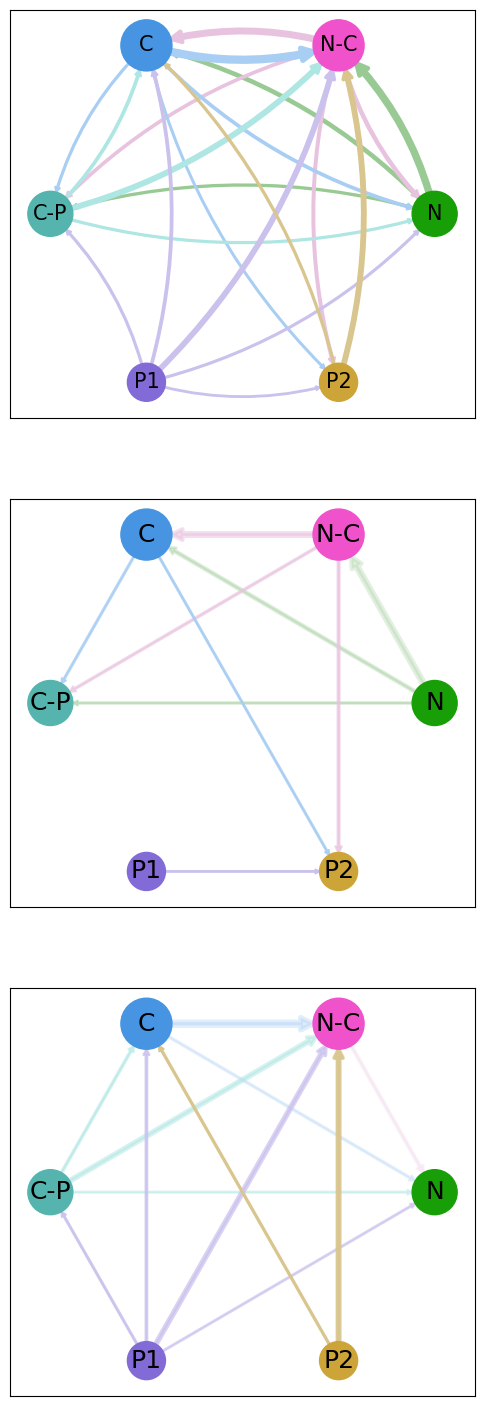

In [2]:
## 生成结构域间网络图
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib as mpl
import numpy as np
import matplotlib.patches

'''1. 读入自己的邻接矩阵并初始化network对象'''
total = np.load('matrix.npy')
G_total = nx.DiGraph()    #记录所有的edges
G_first = nx.DiGraph()    # 从行开始记录edges
G_second = nx.DiGraph()   #从列开始记录edges


'''2. 添加所有的节点'''
nodes =['N','N-C','C','C-P','P1','P2']
G_total.add_nodes_from(nodes)
G_first.add_nodes_from(nodes)
G_second.add_nodes_from(nodes)


'''3. 根据读入的邻接矩阵，添加所有的边'''
for i in range(0,len(nodes)):
    for j in range(0,len(nodes)):
        if total[i][j] != 0:
            G_total.add_weighted_edges_from([(nodes[i],nodes[j],total[i][j])]) # 边的起点，终点，权重 
            if(i<j):
                 G_first.add_weighted_edges_from([(nodes[i],nodes[j],total[i][j])]) # 边的起点，终点，权重
            else:
                 G_second.add_weighted_edges_from([(nodes[i],nodes[j],total[i][j])]) # 边的起点，终点，权重
        else:
            pass

'''4. 根据实际情况设置一些参数，决定节点和边的颜色以及大小等'''

#首先获取边的权重,并可以设定一个阈值，将边的权重值小于阈值的设置成虚线，大于阈值的设置成实线，并根据权重大小决定实线的粗细
# weights = nx.get_edge_attributes(G_total, 'weight')   #这样获得的权值储存在字典里
weights_total = [(u,v,d['weight']) for u,v,d in G_total.edges(data=True)]   #这样获得的权值储存在一个列表的元组里
elarge_total=[(u,v) for (u,v,d) in G_total.edges(data=True) if d['weight'] >0.1]  
esmall_total=[(u,v) for (u,v,d) in G_total.edges(data=True) if d['weight'] <=0.1]

weights_first = [(u,v,d['weight']) for u,v,d in G_first.edges(data=True)]   #这样获得的权值储存在一个列表的元组里
elarge_first=[(u,v) for (u,v,d) in G_first.edges(data=True) if d['weight'] >0.1]  
esmall_first=[(u,v) for (u,v,d) in G_first.edges(data=True) if d['weight'] <=0.1]

weights_second = [(u,v,d['weight']) for u,v,d in G_second.edges(data=True)]   #这样获得的权值储存在一个列表的元组里
elarge_second=[(u,v) for (u,v,d) in G_second.edges(data=True) if d['weight'] >0.1]  
esmall_second=[(u,v) for (u,v,d) in G_second.edges(data=True) if d['weight'] <=0.1]

#自主设置节点位置
pos_total = nx.circular_layout(G_total)
#pos={'b1':(38,75),'diml':(40,80),'disl':(42,75),
     #'zl':(37,64),'b2':(40,65), 'el':(43,64),
     #'b3':(38,53)}
pos_first = nx.circular_layout(G_first)
#pos={'b1':(38,75),'diml':(40,80),'disl':(42,75),
     #'zl':(37,64),'b2':(40,65), 'el':(43,64),
     #'b3':(38,53)}
pos_second = nx.circular_layout(G_second)
#pos={'b1':(38,75),'diml':(40,80),'disl':(42,75),
     #'zl':(37,64),'b2':(40,65), 'el':(43,64),
     #'b3':(38,53)}
     
#节点大小 ，根据节点的进度值设置其大小       

node_sizes = []
degrees=G_total.degree()

for size in degrees:    #度数值是存储在一个列表里
    ss=size[1]     #原始度值太小，作图看不出来，要乘以一个系数。元组是不允许修改的，因此要先赋值给一个变量，再乘以系数
    ss*=150
    node_sizes.append(ss)


# 节点和边的颜色，自主设置，边的颜色设置成比节点颜色稍浅
node_colors = ['#189f08','#f052cb','#4694e2','#55b4ae','#826bd6','#cda437'] 
edge_colors = ['#9aca94','#e8c3df','#a9cef3','#aee6e3','#cac1ed','#d9c58e']

#边的颜色，根据该边是由哪个节点发出的，就用哪个节点的颜色
edge_colors_total=[]
for weight in weights_total:
    aa=nodes.index(weight[0])     
    edge_colors_total.append(edge_colors[aa])

edge_colors_first=[]
for weight in weights_first:
    aa=nodes.index(weight[0])     
    edge_colors_first.append(edge_colors[aa])
    
edge_colors_second=[]
for weight in weights_second:
    aa=nodes.index(weight[0])     
    edge_colors_second.append(edge_colors[aa])


#设定一个阈值，将边的权重值小于阈值的设置成虚线，大于阈值的设置成实线
elarge_total=[(u,v) for (u,v,d) in G_total.edges(data=True) if d['weight'] >0.1]  
esmall_total=[(u,v) for (u,v,d) in G_total.edges(data=True) if d['weight'] <=0.1]

elarge_first=[(u,v) for (u,v,d) in G_first.edges(data=True) if d['weight'] >0.1]  
esmall_first=[(u,v) for (u,v,d) in G_first.edges(data=True) if d['weight'] <=0.1]

elarge_second=[(u,v) for (u,v,d) in G_second.edges(data=True) if d['weight'] >0.1]  
esmall_second=[(u,v) for (u,v,d) in G_second.edges(data=True) if d['weight'] <=0.1]

#将权重乘以一定系数，不然边太细
#for i in weights:    #如果权重值是存储在一个字典里，字典遍历的是键
    #weights[i]*=10
pp_total=[]                       #如果权重值是存储在一个列表里的元组里，直接遍历列表,这样比上一种字典的遍历麻烦多了
for weight in weights_total:
    ww=weight[2]
    ww*=6                    #乘以一个系数，避免本来的边太细
    pp_total.append(ww)
    
pp_first=[]                       #如果权重值是存储在一个列表里的元组里，直接遍历列表,这样比上一种字典的遍历麻烦多了
for weight in weights_first:
    ww=weight[2]
    ww*=6                    #乘以一个系数，避免本来的边太细
    pp_first.append(ww)
    
pp_second=[]                       #如果权重值是存储在一个列表里的元组里，直接遍历列表,这样比上一种字典的遍历麻烦多了
for weight in weights_second:
    ww=weight[2]
    ww*=6                    #乘以一个系数，避免本来的边太细
    pp_second.append(ww)

M_total = G_total.number_of_edges()
edge_alphas_total = [(3+ i) / (M_total + 2) for i in range(M_total)] #第二个数字是第一个数字减1，第一个数字设置的越小，透明度差值越大

M_first = G_first.number_of_edges()
edge_alphas_first = [(3+ i) / (M_first + 2) for i in range(M_first)] #第二个数字是第一个数字减1，第一个数字设置的越小，透明度差值越大

M_second = G_second.number_of_edges()
edge_alphas_second = [(3+ i) / (M_second + 2) for i in range(M_second)] #第二个数字是第一个数字减1，第一个数字设置的越小，透明度差值越大


'''
edges_small=nx.draw_networkx_edges(G_total,pos,
                       edgelist=esmall,
                       style='dashed'
                      )

edges_large=nx.draw_networkx_edges(G_total, pos,
                       edgelist=elarge,
                       #alpha=0.5,
                       #width=list(weights.values()),  #如果权重值是存在一个字典里，应该这样写
                       width=pp,                 #权重值储存在列表里的元组里
                       #arrowsize=10, 
                       #arrowstyle='fancy',
                       arrowstyle='->',
                       edge_color=edge_colors,
                       connectionstyle='arc3, rad = 0.15'
                    )  
'''


#箭头模式有：Simple，Fancy等
testArrow = matplotlib.patches.ArrowStyle.Simple(head_length=0.4, head_width=.4, tail_width=.1)



fig = plt.figure(figsize=(6, 18), dpi=100)


ax = fig.add_subplot(3,1,1)
nodes_total=nx.draw_networkx_nodes(G_total,pos_total,
                       node_size=node_sizes,
                       node_color=node_colors,
                       #alpha=0.5
                      )
#由于在networkx中，箭头大小不能像边的粗细或者颜色一样直接传入一个list，只能传入一个数，因此用循环分别画边
for i in range(M_total):
    nx.draw_networkx_edges(G_total, pos_total,
                       node_size=node_sizes,
                       edgelist=[(elarge_total[i][0],elarge_total[i][1])],
                       #alpha=edge_alphas_total[i],
                       #width=list(weights.values()),  #如果权重值是存在一个字典里，应该这样写
                       width=pp_total[i],                 #权重值储存在列表里的元组里
                       arrowsize=pp_total[i]*6,         #箭头的大小也和权重有关
                       #arrowstyle='fancy',
                       #arrowstyle='->',
                       arrowstyle=testArrow,
                       edge_color=edge_colors_total[i],
                       connectionstyle='arc3, rad = 0.15',
                      )  
nx.draw_networkx_labels(G_total,pos_total,
                        font_size=15
                       )



ax1 = fig.add_subplot(3,1,2)

nodes_first=nx.draw_networkx_nodes(G_first,pos_first,
                       node_size=node_sizes,
                       node_color=node_colors,
                       #alpha=0.5
                      )

#由于在networkx中，箭头大小不能像边的粗细或者颜色一样直接传入一个list，只能传入一个数，因此用循环分别画边
for i in range(M_first):
    nx.draw_networkx_edges(G_first, pos_first,
                       node_size=node_sizes,
                       edgelist=[(elarge_first[i][0],elarge_first[i][1])],
                       alpha=edge_alphas_first[i],
                       #width=list(weights.values()),  #如果权重值是存在一个字典里，应该这样写
                       width=pp_first[i],                 #权重值储存在列表里的元组里
                       arrowsize=pp_first[i]*6,         #箭头的大小也和权重有关
                       #arrowstyle='fancy',
                       #arrowstyle='->',
                       arrowstyle=testArrow,
                       edge_color=edge_colors_first[i],
                       #connectionstyle='arc3, rad = 0.15',
                      )  
nx.draw_networkx_labels(G_first,pos_first,
                        font_size=18
                       )




ax2 = fig.add_subplot(3,1,3)
nodes_total=nx.draw_networkx_nodes(G_second,pos_second,
                       node_size=node_sizes,
                       node_color=node_colors,
                       #alpha=0.5
                      )
#由于在networkx中，箭头大小不能像边的粗细或者颜色一样直接传入一个list，只能传入一个数，因此用循环分别画边
for i in range(M_second):
    nx.draw_networkx_edges(G_second, pos_second,
                       node_size=node_sizes,
                       edgelist=[(elarge_second[i][0],elarge_second[i][1])],
                       alpha=edge_alphas_second[i],
                       #width=list(weights.values()),  #如果权重值是存在一个字典里，应该这样写
                       width=pp_second[i],                 #权重值储存在列表里的元组里
                       arrowsize=pp_second[i]*6,         #箭头的大小也和权重有关
                       #arrowstyle='fancy',
                       #arrowstyle='->',
                       arrowstyle=testArrow,
                       edge_color=edge_colors_second[i],
                       #connectionstyle='arc3, rad = 0.15',
                      )  
nx.draw_networkx_labels(G_second,pos_second,
                        font_size=18
                       )
# 获取每个节点的总边数
node_degrees = dict(G_total.degree())

# 获取邻接矩阵中的节点顺序
node_order = list(G_total.nodes())

# 将节点度数按真实顺序写入文本文件
with open('node_degrees.txt', 'w') as file:
    file.write('Node\tDegree\n')
    for node in node_order:
        degree = node_degrees[node]
        file.write(f'{node}\t{degree}\n')

print("节点度数已成功按真实顺序写入 node_degrees.txt 文件。")
plt.savefig('./network.png',dpi=600)
plt.show()
# 保存结构域信息为cytoscape软件可识别的文件格式
nx.write_graphml(G_total,"network_total.graphml")
nx.write_graphml(G_first,"network_first.graphml")
nx.write_graphml(G_second,"network_second.graphml")

#plt.show()

In [11]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib as mpl
import numpy as np
import matplotlib.patches

# 1. 读取邻接矩阵
total = np.load('matrix.npy')
nodes = ['N', 'N-C', 'C', 'C-P', 'P1', 'P2']

# 2. 创建图
G_total = nx.DiGraph()
G_first = nx.DiGraph()
G_second = nx.DiGraph()
G_total.add_nodes_from(nodes)
G_first.add_nodes_from(nodes)
G_second.add_nodes_from(nodes)

for i in range(len(nodes)):
    for j in range(len(nodes)):
        if total[i][j] != 0:
            G_total.add_edge(nodes[i], nodes[j], weight=total[i][j])
            if i < j:
                G_first.add_edge(nodes[i], nodes[j], weight=total[i][j])
            else:
                G_second.add_edge(nodes[i], nodes[j], weight=total[i][j])

# 3. 节点位置、颜色、大小
pos_total = nx.circular_layout(G_total)
pos_first = nx.circular_layout(G_first)
pos_second = nx.circular_layout(G_second)

node_colors = ['#189f08', '#f052cb', '#4694e2', '#55b4ae', '#826bd6', '#cda437']
edge_colors = ['#9aca94', '#e8c3df', '#a9cef3', '#aee6e3', '#cac1ed', '#d9c58e']
node_sizes = [G_total.degree(n)*150 for n in nodes]

def get_edge_color(G, weights):
    colors = []
    for (u, v, w) in weights:
        idx = nodes.index(u)
        colors.append(edge_colors[idx])
    return colors

def get_edge_alpha(weight_list, inverse_scale=2.0):
    # 归一化反比透明度：高权重 => 低透明度
    weights = np.array([w for (_, _, w) in weight_list])
    max_w = np.max(weights)
    return [1.0 - (w / max_w) * 0.7 for w in weights]

def draw_network(G, pos, weights, filename, title=None):
    fig, ax = plt.subplots(figsize=(6, 6), dpi=600)
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors)
    nx.draw_networkx_labels(G, pos, font_size=12)

    colors = get_edge_color(G, weights)
    widths = [w * 5 for (_, _, w) in weights]
    alphas = get_edge_alpha(weights)

    testArrow = mpl.patches.ArrowStyle.Simple(head_length=0.4, head_width=.4, tail_width=.1)

    for i, (u, v, w) in enumerate(weights):
        nx.draw_networkx_edges(
            G, pos,
            edgelist=[(u, v)],
            width=widths[i],
            arrowsize=widths[i]*3,
            edge_color=colors[i],
            alpha=alphas[i],
            arrowstyle=testArrow,
            connectionstyle='arc3, rad=0.15'
        )

    if title:
        ax.set_title(title, fontsize=14)
    ax.axis('off')
    plt.tight_layout()
    plt.savefig(filename, dpi=600)
    plt.close()

# 4. 绘图保存
weights_total = [(u, v, d['weight']) for u, v, d in G_total.edges(data=True)]
weights_first = [(u, v, d['weight']) for u, v, d in G_first.edges(data=True)]
weights_second = [(u, v, d['weight']) for u, v, d in G_second.edges(data=True)]

draw_network(G_total, pos_total, weights_total, 'network_total.png', title='All Edges')
draw_network(G_first, pos_first, weights_first, 'network_first.png', title='Upper Triangular Edges')
draw_network(G_second, pos_second, weights_second, 'network_second.png', title='Lower Triangular Edges')

# 保存为 Cytoscape 支持格式
nx.write_graphml(G_total, "network_total.graphml")
nx.write_graphml(G_first, "network_first.graphml")
nx.write_graphml(G_second, "network_second.graphml")

# 输出节点度数
node_degrees = dict(G_total.degree())
with open('node_degrees.txt', 'w') as f:
    f.write('Node\tDegree\n')
    for node in nodes:
        f.write(f'{node}\t{node_degrees[node]}\n')

print("✅ 三张图已分别保存，文件名为：network_total.png, network_first.png, network_second.png")


✅ 三张图已分别保存，文件名为：network_total.png, network_first.png, network_second.png


平均路径长度: 1.4168831168831169
有效直径: 2.0
所有节点的总度数: 17960
所有节点的平均度数: 102.04545454545455


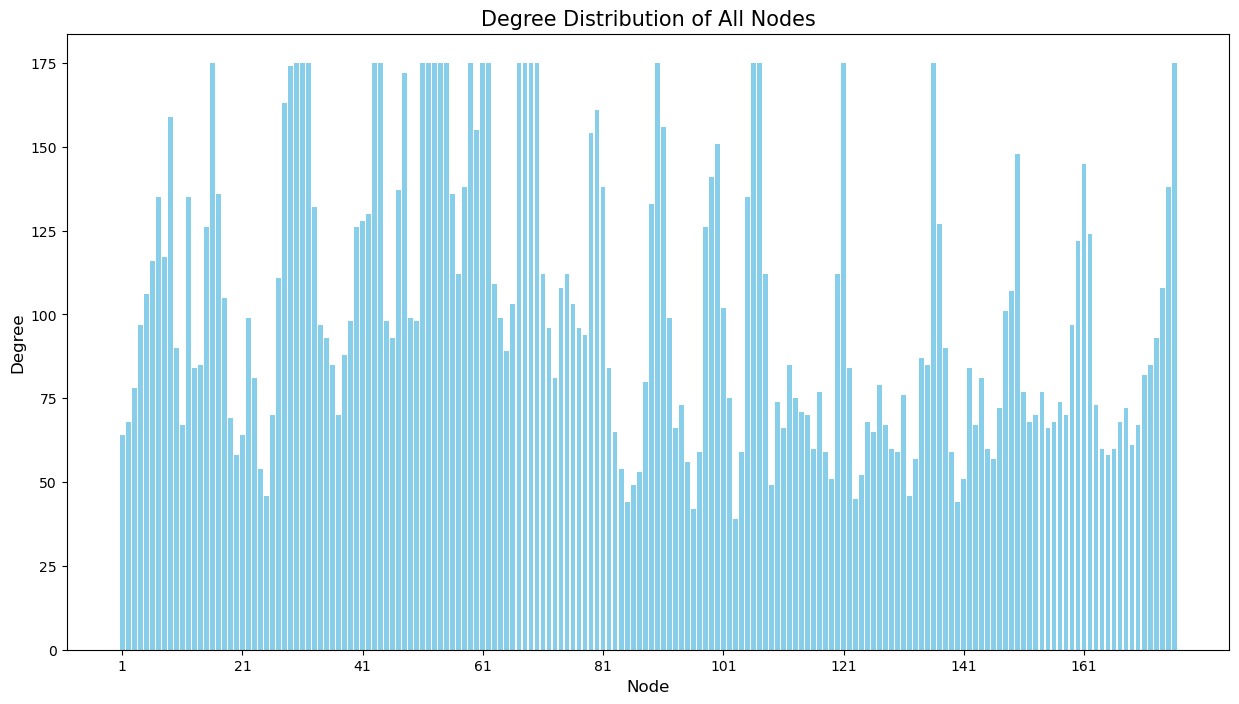

所有节点的总权重: 8245.192862128306
所有节点的平均权重: 46.8476867166381


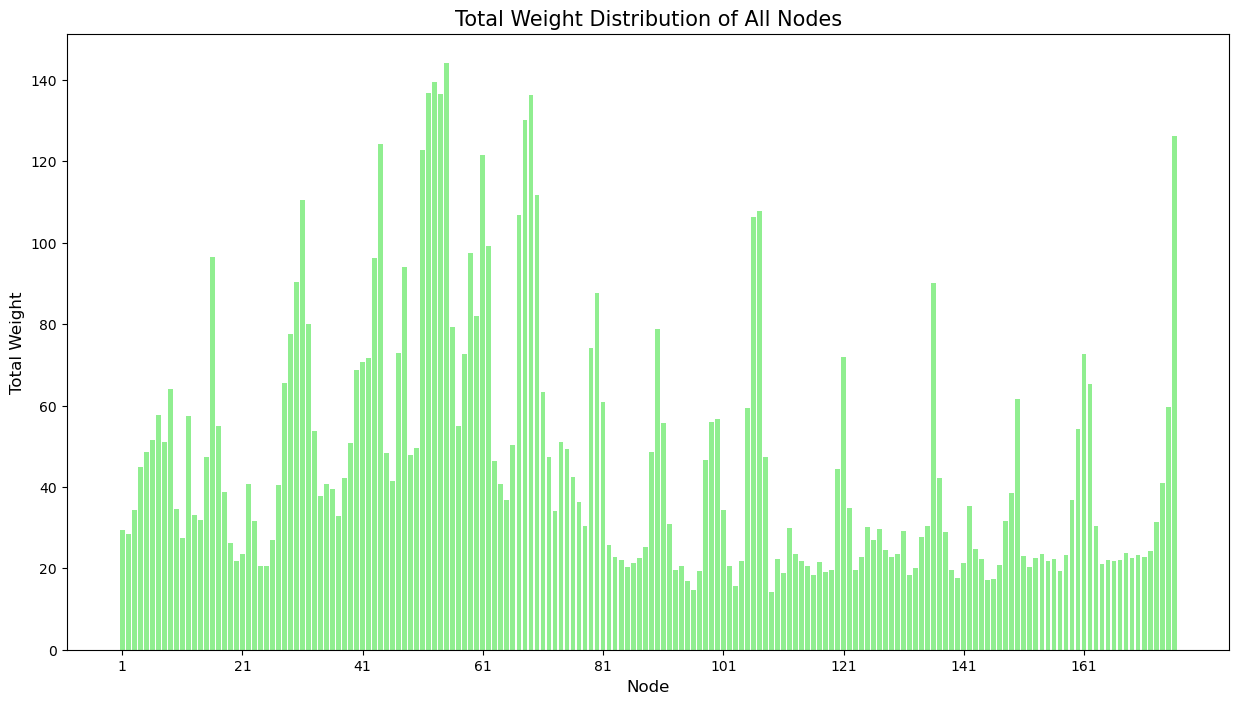

总度中心性: 102.62857142857138
平均度中心性: 0.5831168831168828


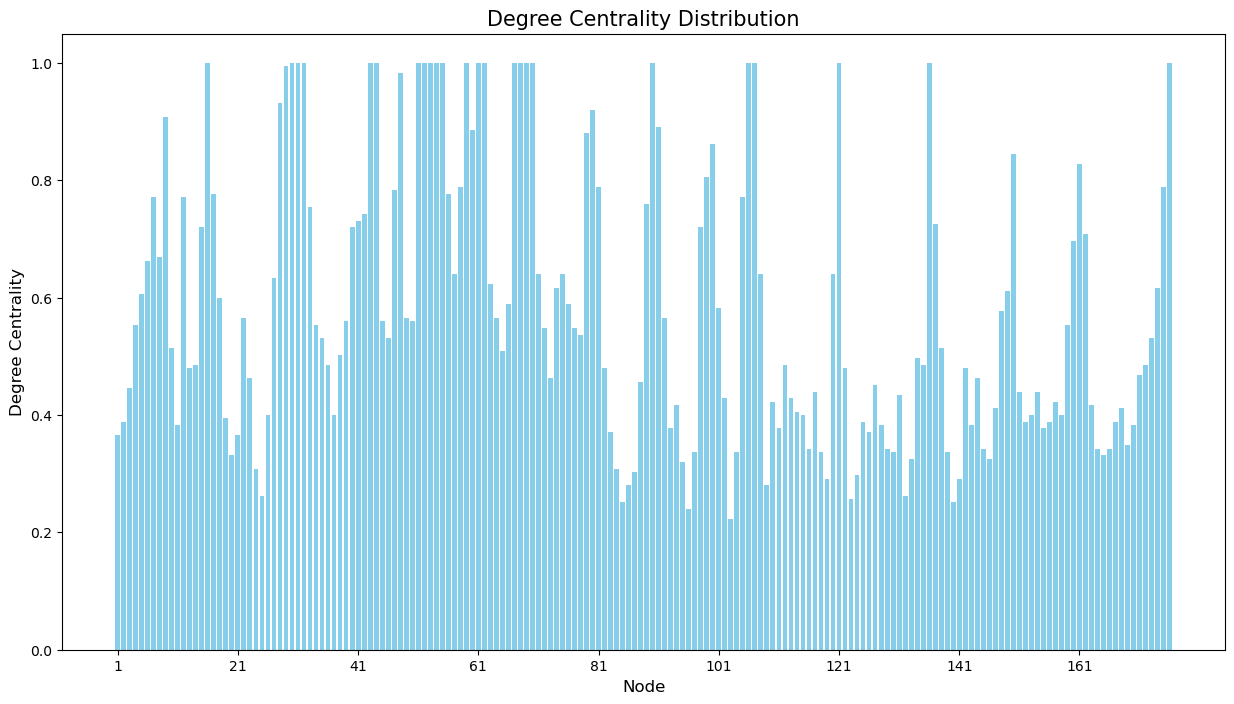

总接近中心性: 128.24443856354395
平均接近中心性: 0.7286615827474088


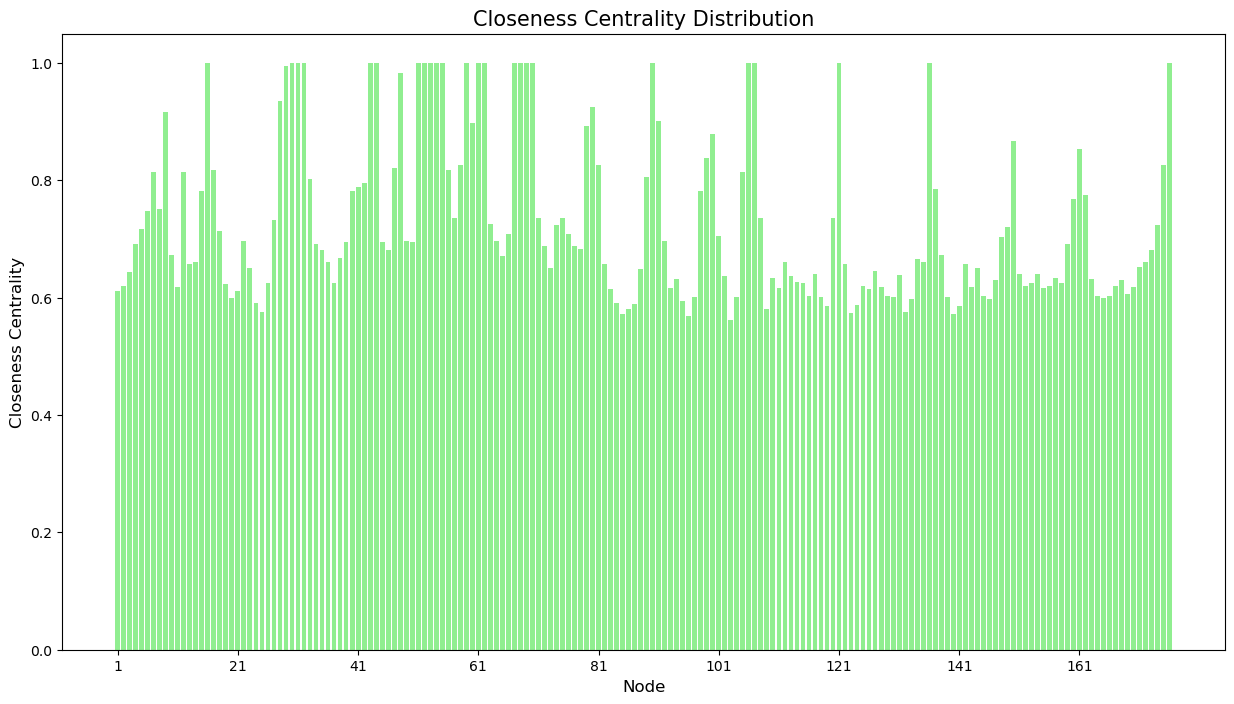

总中介中心性: 0.4216748768472907
平均中介中心性: 0.002395879982086879


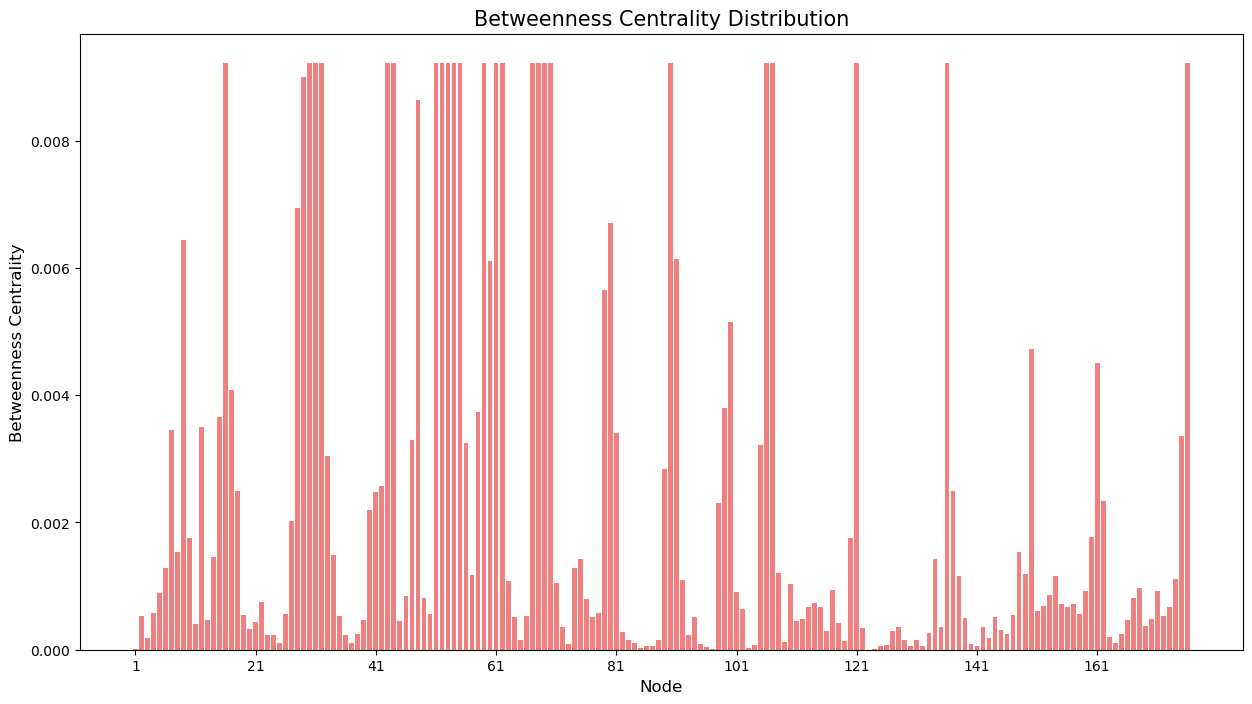

总特征向量中心性: 12.632775474350058
平均特征向量中心性: 0.07177713337698897


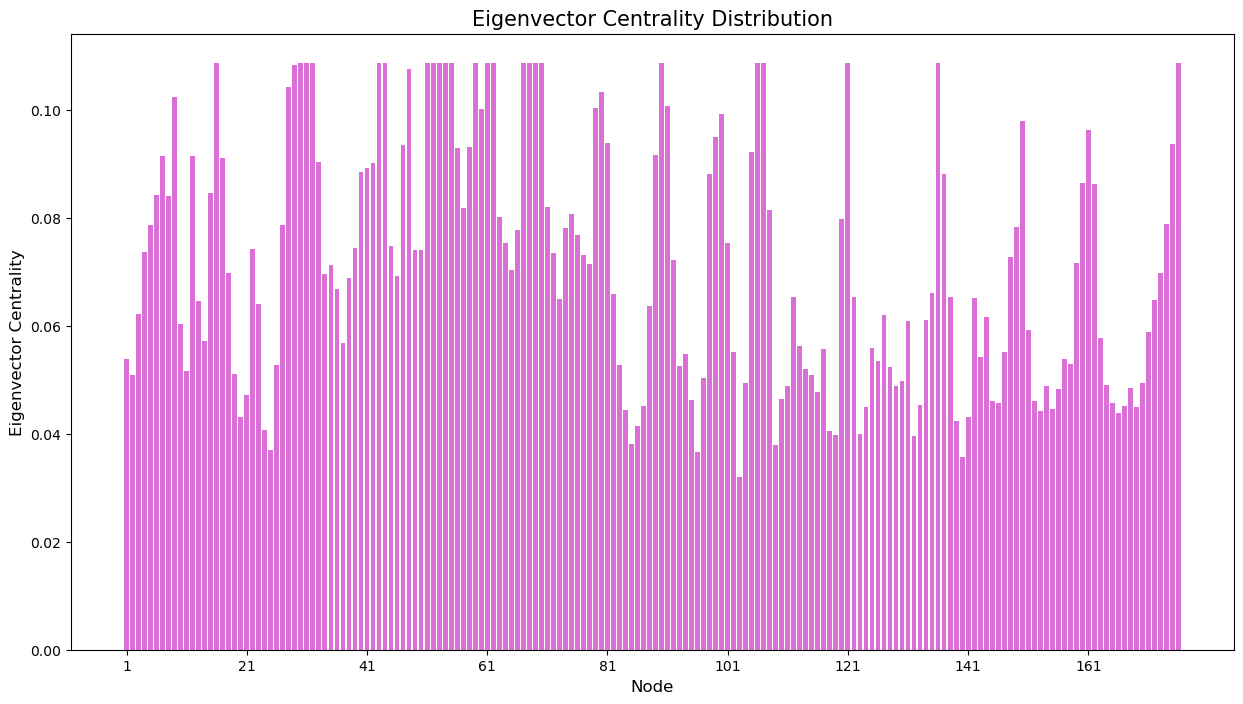

平均聚类系数: 0.7932354609027701
总三角形数: 248922


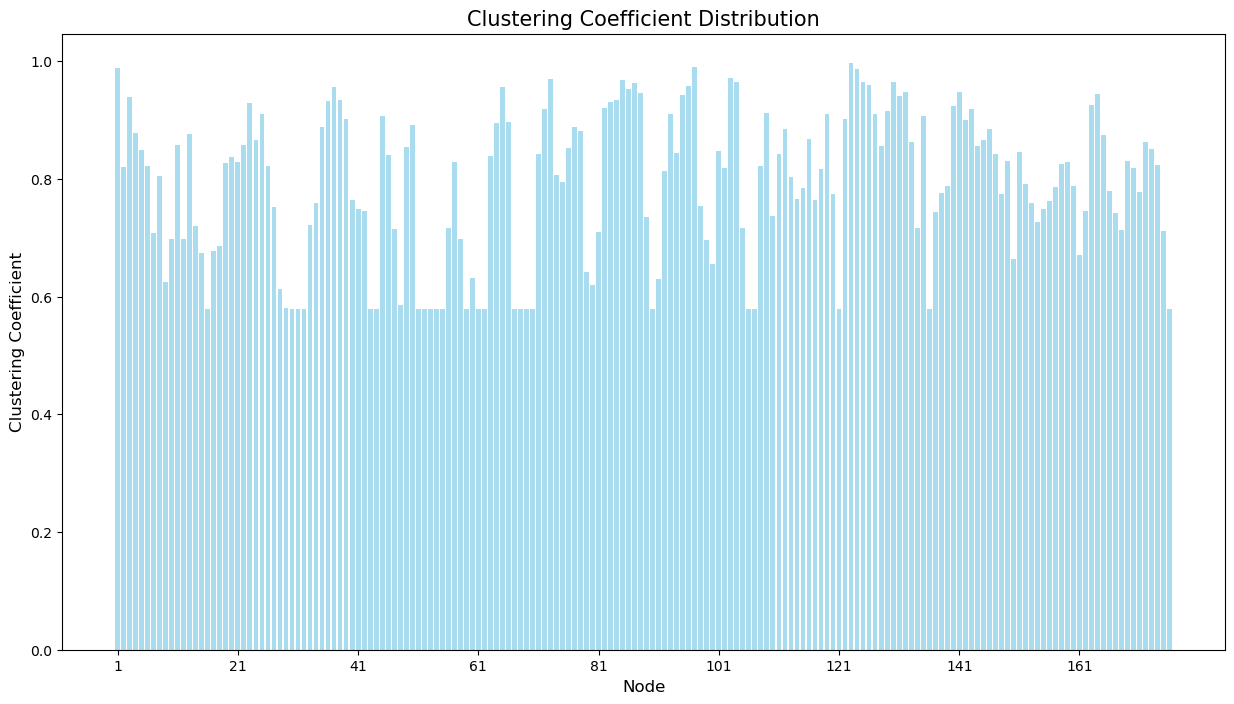

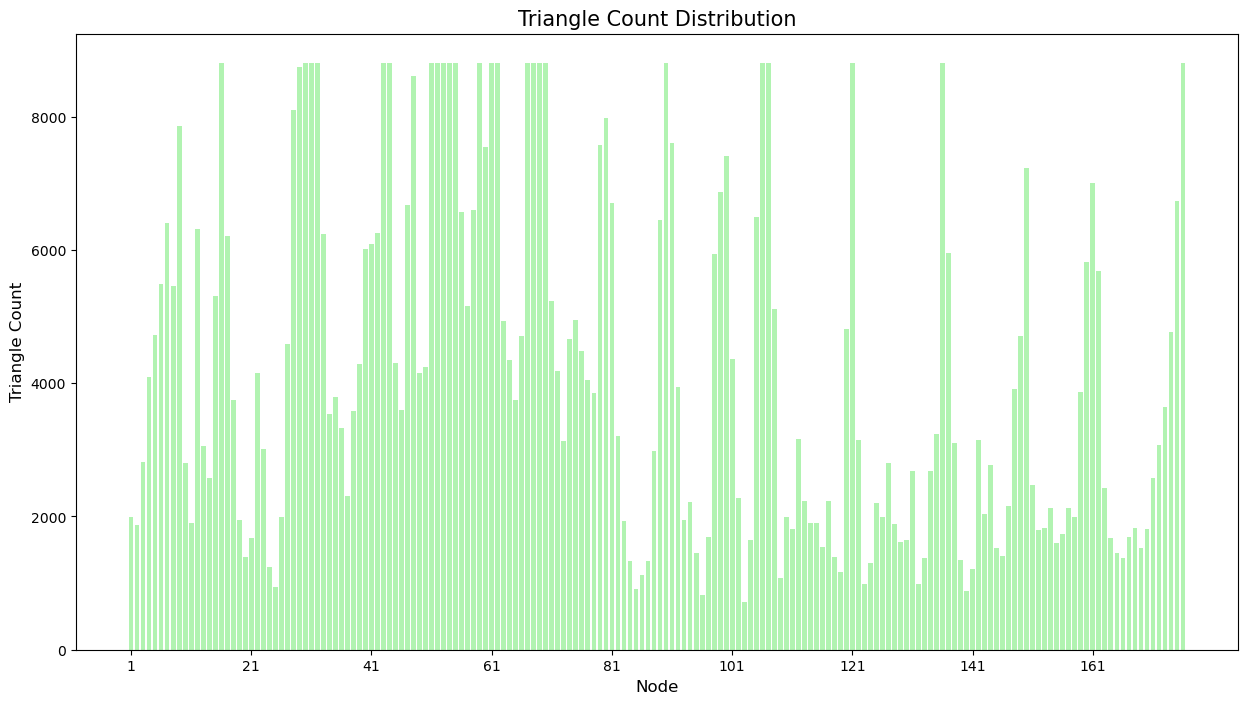

In [10]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 1. 从邻接矩阵创建图对象
matrix = np.load('WT_interactions.npy')
G = nx.from_numpy_array(matrix)

# 2. 计算网络直径（有效直径）和平均路径长度
def effective_diameter(G, percentile=90):
    lengths = dict(nx.all_pairs_shortest_path_length(G))
    all_lengths = []
    for source, target_dict in lengths.items():
        all_lengths.extend(target_dict.values())
    return np.percentile(all_lengths, percentile)

avg_path_length = nx.average_shortest_path_length(G)
effective_diameter_value = effective_diameter(G)

print(f"平均路径长度: {avg_path_length}")
print(f"有效直径: {effective_diameter_value}")

# 3. 度数分析
# 计算节点总度数
degree_dict = dict(G.degree())

# 打印所有节点的总度数
total_degree = sum(degree_dict.values())
average_degree = total_degree / len(degree_dict)
print(f"所有节点的总度数: {total_degree}")
print(f"所有节点的平均度数: {average_degree}")

# 绘制所有节点的度数分布图
plt.figure(figsize=(15, 8))
plt.bar(range(1, len(degree_dict)+1), degree_dict.values(), color='skyblue')
plt.xlabel('Node', fontsize=12)
plt.ylabel('Degree', fontsize=12)
plt.title('Degree Distribution of All Nodes', fontsize=15)
plt.xticks(range(1, len(degree_dict)+1, 20), range(1, len(degree_dict)+1, 20), rotation='horizontal', fontsize=10)
plt.yticks(fontsize=10)
plt.savefig('./degree_distribution_all_nodes.png')
plt.show()

# 4. 权重分析
# 计算每个节点的总权重
total_weight_dict = {node: sum(weight for _, _, weight in G.edges(node, data='weight', default=1)) for node in G.nodes()}

# 计算所有节点的总权重
total_weight = sum(total_weight_dict.values())
average_weight = total_weight / len(total_weight_dict)
print(f"所有节点的总权重: {total_weight}")
print(f"所有节点的平均权重: {average_weight}")

# 绘制所有节点的总权重分布图
plt.figure(figsize=(15, 8))
plt.bar(range(1, len(total_weight_dict)+1), total_weight_dict.values(), color='lightgreen')
plt.xlabel('Node', fontsize=12)
plt.ylabel('Total Weight', fontsize=12)
plt.title('Total Weight Distribution of All Nodes', fontsize=15)
plt.xticks(range(1, len(total_weight_dict)+1, 20), range(1, len(total_weight_dict)+1, 20), rotation='horizontal', fontsize=10)
plt.yticks(fontsize=10)
plt.savefig('./total_weight_distribution_all_nodes.png')
plt.show()

# 5. 计算并打印总度中心性和绘制度中心性分布图
degree_centrality = nx.degree_centrality(G)
total_degree_centrality = sum(degree_centrality.values())
average_degree_centrality = total_degree_centrality / len(degree_centrality)
print(f"总度中心性: {total_degree_centrality}")
print(f"平均度中心性: {average_degree_centrality}")

plt.figure(figsize=(15, 8))
plt.bar(range(1, len(degree_centrality)+1), degree_centrality.values(), color='skyblue')
plt.xlabel('Node', fontsize=12)
plt.ylabel('Degree Centrality', fontsize=12)
plt.title('Degree Centrality Distribution', fontsize=15)
plt.xticks(range(1, len(degree_centrality)+1, 20), range(1, len(degree_centrality)+1, 20), rotation='horizontal', fontsize=10)
plt.yticks(fontsize=10)
plt.savefig('./degree_centrality_distribution.png')
plt.show()

# 6. 计算并打印总接近中心性和绘制接近中心性分布图
closeness_centrality = nx.closeness_centrality(G)
total_closeness_centrality = sum(closeness_centrality.values())
average_closeness_centrality = total_closeness_centrality / len(closeness_centrality)
print(f"总接近中心性: {total_closeness_centrality}")
print(f"平均接近中心性: {average_closeness_centrality}")

plt.figure(figsize=(15, 8))
plt.bar(range(1, len(closeness_centrality)+1), closeness_centrality.values(), color='lightgreen')
plt.xlabel('Node', fontsize=12)
plt.ylabel('Closeness Centrality', fontsize=12)
plt.title('Closeness Centrality Distribution', fontsize=15)
plt.xticks(range(1, len(closeness_centrality)+1, 20), range(1, len(closeness_centrality)+1, 20), rotation='horizontal', fontsize=10)
plt.yticks(fontsize=10)
plt.savefig('./closeness_centrality_distribution.png')
plt.show()

# 7. 计算并打印总中介中心性和绘制中介中心性分布图
betweenness_centrality = nx.betweenness_centrality(G)
total_betweenness_centrality = sum(betweenness_centrality.values())
average_betweenness_centrality = total_betweenness_centrality / len(betweenness_centrality)
print(f"总中介中心性: {total_betweenness_centrality}")
print(f"平均中介中心性: {average_betweenness_centrality}")

plt.figure(figsize=(15, 8))
plt.bar(range(1, len(betweenness_centrality)+1), betweenness_centrality.values(), color='lightcoral')
plt.xlabel('Node', fontsize=12)
plt.ylabel('Betweenness Centrality', fontsize=12)
plt.title('Betweenness Centrality Distribution', fontsize=15)
plt.xticks(range(1, len(betweenness_centrality)+1, 20), range(1, len(betweenness_centrality)+1, 20), rotation='horizontal', fontsize=10)
plt.yticks(fontsize=10)
plt.savefig('./betweenness_centrality_distribution.png')
plt.show()

# 8. 计算并打印总特征向量中心性和绘制特征向量中心性分布图
eigenvector_centrality = nx.eigenvector_centrality(G)
total_eigenvector_centrality = sum(eigenvector_centrality.values())
average_eigenvector_centrality = total_eigenvector_centrality / len(eigenvector_centrality)
print(f"总特征向量中心性: {total_eigenvector_centrality}")
print(f"平均特征向量中心性: {average_eigenvector_centrality}")

plt.figure(figsize=(15, 8))
plt.bar(range(1, len(eigenvector_centrality)+1), eigenvector_centrality.values(), color='orchid')
plt.xlabel('Node', fontsize=12)
plt.ylabel('Eigenvector Centrality', fontsize=12)
plt.title('Eigenvector Centrality Distribution', fontsize=15)
plt.xticks(range(1, len(eigenvector_centrality)+1, 20), range(1, len(eigenvector_centrality)+1, 20), rotation='horizontal', fontsize=10)
plt.yticks(fontsize=10)
plt.savefig('./eigenvector_centrality_distribution.png')
plt.show()

# 9. 计算平均聚类系数和总三角形数
clustering_coefficient = nx.average_clustering(G)
triangles = nx.triangles(G)
total_triangles = sum(triangles.values()) // 3

print(f"平均聚类系数: {clustering_coefficient}")
print(f"总三角形数: {total_triangles}")

# 计算每个节点的聚类系数和三角形计数
node_clustering_coefficients = nx.clustering(G)
node_triangles = nx.triangles(G)

# 获取节点列表和对应的聚类系数、三角形计数
nodes = list(G.nodes())
clustering_values = [node_clustering_coefficients[node] for node in nodes]
triangle_counts = [node_triangles[node] for node in nodes]

# 绘制聚类系数分布图（柱状图）
plt.figure(figsize=(15, 8))
plt.bar(range(1, len(nodes)+1), clustering_values, color='skyblue', alpha=0.7)
plt.xlabel('Node', fontsize=12)
plt.ylabel('Clustering Coefficient', fontsize=12)
plt.title('Clustering Coefficient Distribution', fontsize=15)
plt.xticks(range(1, len(nodes)+1, 20), range(1, len(nodes)+1, 20), rotation='horizontal', fontsize=10)
plt.yticks(fontsize=10)
plt.savefig('./clustering_coefficient_distribution.png')
plt.show()

# 绘制三角形计数分布图（柱状图）
plt.figure(figsize=(15, 8))
plt.bar(range(1, len(nodes)+1), triangle_counts, color='lightgreen', alpha=0.7)
plt.xlabel('Node', fontsize=12)
plt.ylabel('Triangle Count', fontsize=12)
plt.title('Triangle Count Distribution', fontsize=15)
plt.xticks(range(1, len(nodes)+1, 20), range(1, len(nodes)+1, 20), rotation='horizontal', fontsize=10)
plt.yticks(fontsize=10)
plt.savefig('./triangle_count_distribution.png')
plt.show()


p-loop区域节点信息（按度中心性降序）：
节点 31 - 度中心性: 1.0, 权重: 110.51368011175582
节点 16 - 度中心性: 1.0, 权重: 96.58415823572098
节点 30 - 度中心性: 1.0, 权重: 90.4129856622951
节点 32 - 度中心性: 1.0, 权重: 80.06519000221684
节点 29 - 度中心性: 0.9942857142857143, 权重: 77.54767161534373
节点 28 - 度中心性: 0.9314285714285714, 权重: 65.55008036952584
节点 9 - 度中心性: 0.9085714285714286, 权重: 64.04737475628474
节点 17 - 度中心性: 0.7771428571428571, 权重: 54.87720638853747
节点 7 - 度中心性: 0.7714285714285715, 权重: 57.764921241927446
节点 12 - 度中心性: 0.7714285714285715, 权重: 57.498286485190924
节点 33 - 度中心性: 0.7542857142857143, 权重: 53.807506083012655
节点 15 - 度中心性: 0.72, 权重: 47.340112022094495
节点 8 - 度中心性: 0.6685714285714286, 权重: 51.07554743933246
节点 6 - 度中心性: 0.6628571428571428, 权重: 51.64644641649318
节点 27 - 度中心性: 0.6342857142857142, 权重: 40.44247207923959
节点 5 - 度中心性: 0.6057142857142858, 权重: 48.48096705648059
节点 18 - 度中心性: 0.6, 权重: 38.66044377674423
节点 22 - 度中心性: 0.5657142857142857, 权重: 40.759305063835626
节点 4 - 度中心性: 0.5542857142857143, 权重: 44.773626001587644
节点

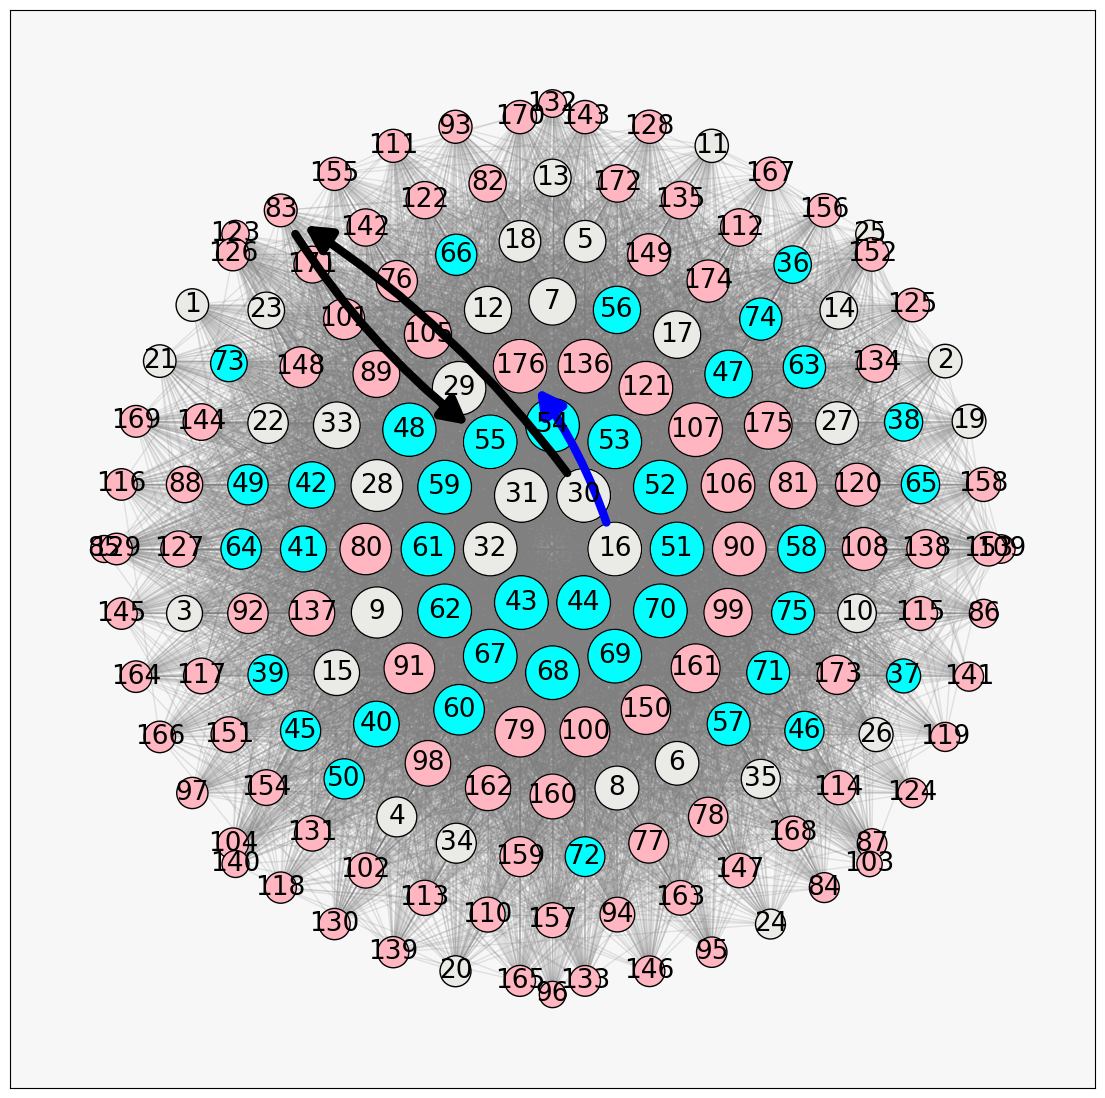

In [15]:
# 最短路径分析
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# 精细同心圆布局，基于大小进行定位并确保所有节点都在内部，调整层密度
def refined_concentric_layout_final_adjustment(G, sizes, scale=1):
    pos = {}
    sorted_nodes = sorted(G.nodes, key=lambda n: sizes[n], reverse=True)
    num_layers = int(np.ceil(np.sqrt(len(sorted_nodes))))

    layer = 1
    count = 0
    while count < len(sorted_nodes) - 11:  # 确保外层有足够的节点
        nodes_in_layer = 6 * layer  # 减少内层节点以使其更稀疏
        nodes = sorted_nodes[count:count + nodes_in_layer]
        angle_step = 2 * np.pi / len(nodes)
        for i, node in enumerate(nodes):
            angle = i * angle_step
            r = scale * layer
            pos[node] = (r * np.cos(angle), r * np.sin(angle))
        count += nodes_in_layer
        layer += 1

    # 将剩余的节点放在最外层，使其更紧凑
    remaining_nodes = sorted_nodes[count:]
    angle_step = 2 * np.pi / len(remaining_nodes)
    for i, node in enumerate(remaining_nodes):
        angle = i * angle_step
        r = scale * (layer - 0.8)  # 调整半径使最外层更紧凑
        pos[node] = (r * np.cos(angle), r * np.sin(angle))

    return pos

# 自定义函数在边缘上绘制箭头
def draw_arrows(G, pos, path_edges, ax, arrow_color, arrow_width=1.5, line_width=2.5):
    for edge in path_edges:
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        # 调整坐标使箭头出现在节点外部
        arrowprops = dict(arrowstyle='-|>,head_length=1.5,head_width=0.8',
                          color=arrow_color,
                          lw=6,  # 加粗线条和箭头
                          alpha=1,  # 使箭头和目标节点颜色一致
                          shrinkA=20, shrinkB=20,  # 增加缩减量以避免箭头嵌入节点
                          connectionstyle='arc3,rad=0.1')
        ax.annotate('', xy=(x1, y1), xytext=(x0, y0), arrowprops=arrowprops)

# 加载邻接矩阵
file_path = './logs/WT_interactions.npy'
matrix = np.load(file_path)

# 从邻接矩阵创建图对象
G = nx.from_numpy_array(matrix)

# 计算度中心性并转换为节点大小
degree_centrality = nx.degree_centrality(G)
node_sizes = [v * 1500 for v in degree_centrality.values()]  # 调整节点大小

# 生成基于大小定位的精细同心圆布局，确保所有节点都在内部并调整层密度
pos = refined_concentric_layout_final_adjustment(G, degree_centrality, scale=3)

# 统一所有节点的大背景颜色
node_colors = ['#eaeae6' for _ in range(len(G.nodes))]  # 使用浅绿色作为背景颜色

# p-loop、Switch 1和Switch 2范围
p_loop_range = list(range(0, 35))
switch_1_range = list(range(35, 75))
switch_2_range = list(range(75, 176))

# 设置p-loop、Switch 1和Switch 2节点的颜色
p_loop_color = '#eaeae6'
switch_1_color = 'cyan'
switch_2_color = 'lightpink'

# 计算节点的权重
def compute_node_weights(G):
    return {node: sum(weight for _, _, weight in G.edges(node, data='weight', default=1)) for node in G.nodes()}

node_weights = compute_node_weights(G)

# 打印p-loop、Switch 1和Switch 2范围内节点的度中心性和权重
print("p-loop区域节点信息（按度中心性降序）：")
p_loop_info = [(node, degree_centrality[node], node_weights[node]) for node in p_loop_range]
p_loop_info.sort(key=lambda x: (-x[1], -x[2]))
for node, degree, weight in p_loop_info:
    print(f"节点 {node+1} - 度中心性: {degree}, 权重: {weight}")

print("\nSwitch 1区域节点信息（按度中心性降序）：")
switch_1_info = [(node, degree_centrality[node], node_weights[node]) for node in switch_1_range]
switch_1_info.sort(key=lambda x: (-x[1], -x[2]))
for node, degree, weight in switch_1_info:
    print(f"节点 {node+1} - 度中心性: {degree}, 权重: {weight}")

print("\nSwitch 2区域节点信息（按度中心性降序）：")
switch_2_info = [(node, degree_centrality[node], node_weights[node]) for node in switch_2_range]
switch_2_info.sort(key=lambda x: (-x[1], -x[2]))
for node, degree, weight in switch_2_info:
    print(f"节点 {node+1} - 度中心性: {degree}, 权重: {weight}")

# 选择度中心性和权重最高的节点作为起点和终点
start_nodes = [node for node, _, _ in p_loop_info[:3]]
end_nodes_1 = [node for node, _, _ in switch_1_info[:3]]
end_nodes_2 = [node for node, _, _ in switch_2_info[:3]]

# 计算所有可能路径的概率，并选择概率最大的路径
all_paths = []
path_probabilities = []

def find_best_path(start_nodes, end_nodes):
    all_paths = []
    path_probabilities = []
    for start_node in start_nodes:
        for end_node in end_nodes:
            path = nx.shortest_path(G, source=start_node, target=end_node, weight='weight')
            path_probability = np.prod([G[u][v]['weight'] for u, v in zip(path[:-1], path[1:])])
            all_paths.append(path)
            path_probabilities.append(path_probability)
    best_path_index = np.argmax(path_probabilities)
    best_path = all_paths[best_path_index]
    return best_path, all_paths, path_probabilities

best_path_1, all_paths_1, path_probabilities_1 = find_best_path(start_nodes, end_nodes_1)
best_path_2, all_paths_2, path_probabilities_2 = find_best_path(start_nodes, end_nodes_2)

# 打印所有路径的信息和概率（以选定路径的总和为基准）
total_probability_1 = sum(path_probabilities_1)
total_probability_2 = sum(path_probabilities_2)

print("\n所有路径的信息及其概率（到Switch 1）：")
for path, prob in sorted(zip(all_paths_1, path_probabilities_1), key=lambda x: x[1], reverse=True):
    normalized_prob = prob / total_probability_1
    print(f"路径: {[node+1 for node in path]}, 概率: {normalized_prob}")

print("\n所有路径的信息及其概率（到Switch 2）：")
for path, prob in sorted(zip(all_paths_2, path_probabilities_2), key=lambda x: x[1], reverse=True):
    normalized_prob = prob / total_probability_2
    print(f"路径: {[node+1 for node in path]}, 概率: {normalized_prob}")

# 使用同心圆布局和从中心到边缘的颜色渐变绘制网络图
fig, ax = plt.subplots(figsize=(14, 14))  # 调整图形大小

# 绘制所有节点
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, edgecolors='white', alpha=0.8, ax=ax)  # 较亮的边缘颜色以获得更好的对比
nx.draw_networkx_edges(G, pos, alpha=0.2, edge_color='gray', ax=ax)  # 调整边缘透明度

# 绘制最短路径
path_edges_1 = list(zip(best_path_1, best_path_1[1:]))
path_edges_2 = list(zip(best_path_2, best_path_2[1:]))
draw_arrows(G, pos, path_edges_1, ax, arrow_color='black')
draw_arrows(G, pos, path_edges_2, ax, arrow_color='blue')

# 在最短路径中绘制节点
nx.draw_networkx_nodes(G, pos, nodelist=best_path_1, node_size=[node_sizes[node] for node in best_path_1], node_color=[node_colors[node] for node in best_path_1], edgecolors='white', ax=ax)
nx.draw_networkx_nodes(G, pos, nodelist=best_path_2, node_size=[node_sizes[node] for node in best_path_2], node_color=[node_colors[node] for node in best_path_2], edgecolors='white', ax=ax)

# 设置起点和终点节点的颜色
nx.draw_networkx_nodes(G, pos, nodelist=p_loop_range, node_size=[node_sizes[node] for node in p_loop_range], node_color=p_loop_color, edgecolors='black', ax=ax)
nx.draw_networkx_nodes(G, pos, nodelist=switch_1_range, node_size=[node_sizes[node] for node in switch_1_range], node_color=switch_1_color, edgecolors='black', ax=ax)
nx.draw_networkx_nodes(G, pos, nodelist=switch_2_range, node_size=[node_sizes[node] for node in switch_2_range], node_color=switch_2_color, edgecolors='black', ax=ax)

# 使用黑色字体颜色绘制标签
labels = {node: str(node + 1) for node in G.nodes()}
nx.draw_networkx_labels(G, pos, font_size=19, labels=labels, font_color='black', ax=ax)  # 调整字体大小

# 设置背景颜色
ax.set_facecolor('#f7f7f7')

plt.title('' , fontsize=17)
plt.savefig('WT_shortest_paths.png',dpi=600)
plt.show()

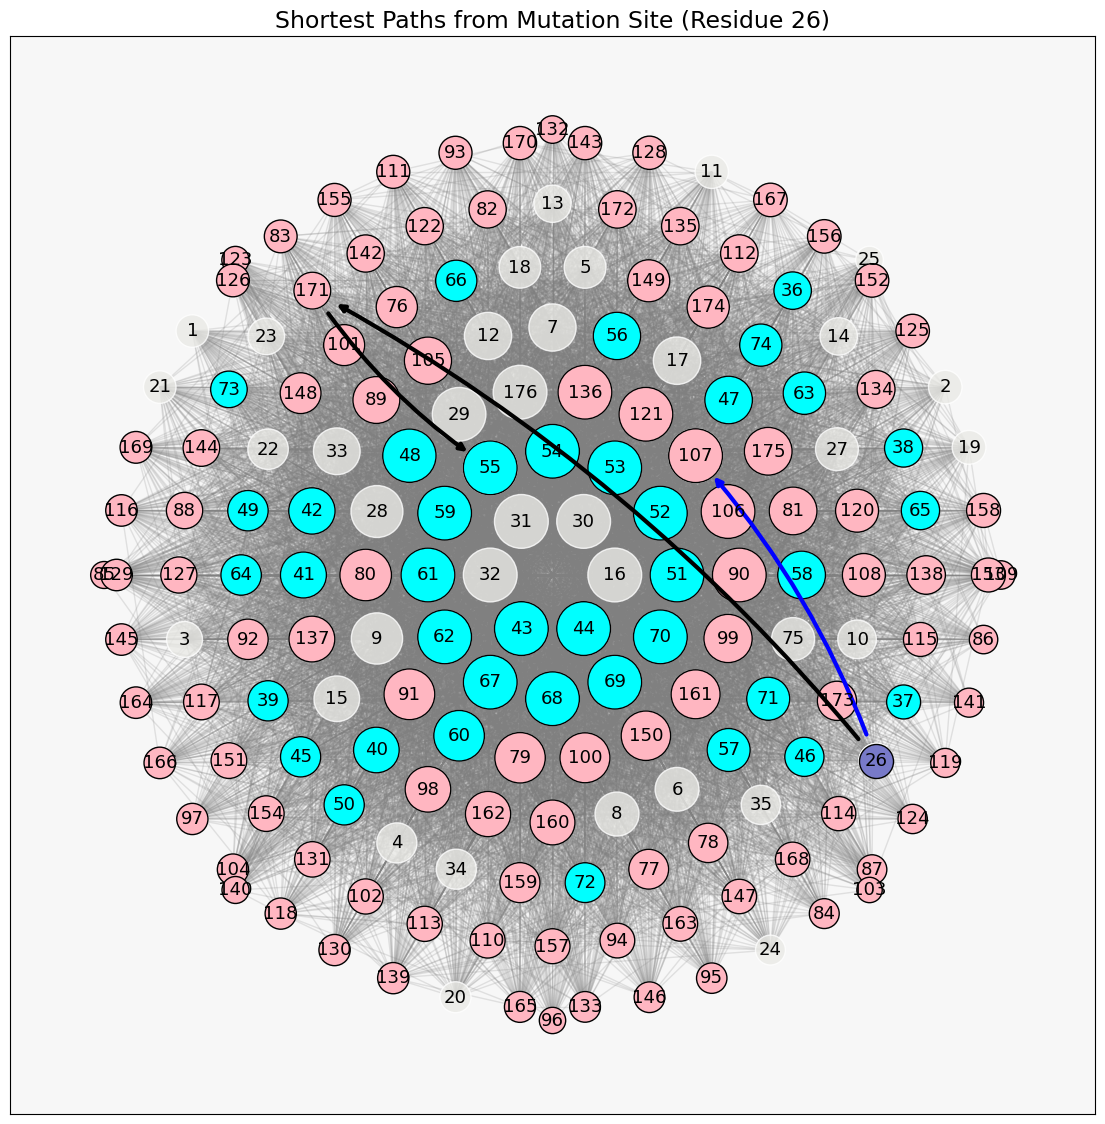

In [12]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

def refined_concentric_layout_final_adjustment(G, sizes, scale=1):
    pos = {}
    sorted_nodes = sorted(G.nodes, key=lambda n: sizes[n], reverse=True)
    num_layers = int(np.ceil(np.sqrt(len(sorted_nodes))))
    layer = 1
    count = 0
    while count < len(sorted_nodes) - 11:
        nodes_in_layer = 6 * layer
        nodes = sorted_nodes[count:count + nodes_in_layer]
        angle_step = 2 * np.pi / len(nodes)
        for i, node in enumerate(nodes):
            angle = i * angle_step
            r = scale * layer
            pos[node] = (r * np.cos(angle), r * np.sin(angle))
        count += nodes_in_layer
        layer += 1
    remaining_nodes = sorted_nodes[count:]
    angle_step = 2 * np.pi / len(remaining_nodes)
    for i, node in enumerate(remaining_nodes):
        angle = i * angle_step
        r = scale * (layer - 0.8)
        pos[node] = (r * np.cos(angle), r * np.sin(angle))
    return pos

def draw_arrows(G, pos, path_edges, ax, arrow_color):
    for edge in path_edges:
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        arrowprops = dict(arrowstyle='-|>', color=arrow_color, lw=3,
                          alpha=1, shrinkA=20, shrinkB=20,
                          connectionstyle='arc3,rad=0.1')
        ax.annotate('', xy=(x1, y1), xytext=(x0, y0), arrowprops=arrowprops)

matrix = np.load('./logs/WT_interactions.npy')
G = nx.from_numpy_array(matrix)

degree_centrality = nx.degree_centrality(G)
node_sizes = [v * 1500 for v in degree_centrality.values()]
pos = refined_concentric_layout_final_adjustment(G, degree_centrality, scale=3)

start_nodes = [25]  # Residue 26
region_1_range = list(range(35, 74))  # Residue 106-221
region_2_range = list(range(75, 175))  # Residue 221-525

start_color = '#787ac9'
region_1_color = 'cyan'
region_2_color = 'lightpink'
node_colors = ['#eaeae6' for _ in range(len(G.nodes))]

def compute_node_weights(G):
    return {node: sum(weight for _, _, weight in G.edges(node, data='weight', default=1)) for node in G.nodes()}
node_weights = compute_node_weights(G)

region_1_info = [(node, degree_centrality[node], node_weights[node]) for node in region_1_range]
region_1_info.sort(key=lambda x: (-x[1], -x[2]))
end_nodes_1 = [node for node, _, _ in region_1_info[:3]]

region_2_info = [(node, degree_centrality[node], node_weights[node]) for node in region_2_range]
region_2_info.sort(key=lambda x: (-x[1], -x[2]))
end_nodes_2 = [node for node, _, _ in region_2_info[:3]]

def find_best_path(start_nodes, end_nodes):
    all_paths = []
    path_probabilities = []
    for start_node in start_nodes:
        for end_node in end_nodes:
            path = nx.shortest_path(G, source=start_node, target=end_node, weight='weight')
            path_probability = np.prod([G[u][v]['weight'] for u, v in zip(path[:-1], path[1:])])
            all_paths.append(path)
            path_probabilities.append(path_probability)
    best_path_index = np.argmax(path_probabilities)
    return all_paths[best_path_index], all_paths, path_probabilities

best_path_1, _, _ = find_best_path(start_nodes, end_nodes_1)
best_path_2, _, _ = find_best_path(start_nodes, end_nodes_2)

fig, ax = plt.subplots(figsize=(14, 14))
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors,
                       edgecolors='white', alpha=0.8, ax=ax)
nx.draw_networkx_edges(G, pos, alpha=0.2, edge_color='gray', ax=ax)

# �� 修改部分：箭头颜色为橙色
draw_arrows(G, pos, list(zip(best_path_1, best_path_1[1:])), ax, arrow_color='black')
draw_arrows(G, pos, list(zip(best_path_2, best_path_2[1:])), ax, arrow_color='blue')

nx.draw_networkx_nodes(G, pos, nodelist=best_path_1,
                       node_size=[node_sizes[n] for n in best_path_1],
                       node_color=[node_colors[n] for n in best_path_1],
                       edgecolors='white', ax=ax)
nx.draw_networkx_nodes(G, pos, nodelist=best_path_2,
                       node_size=[node_sizes[n] for n in best_path_2],
                       node_color=[node_colors[n] for n in best_path_2],
                       edgecolors='white', ax=ax)

nx.draw_networkx_nodes(G, pos, nodelist=start_nodes,
                       node_size=[node_sizes[n] for n in start_nodes],
                       node_color=start_color, edgecolors='black', ax=ax)
nx.draw_networkx_nodes(G, pos, nodelist=region_1_range,
                       node_size=[node_sizes[n] for n in region_1_range],
                       node_color=region_1_color, edgecolors='black', ax=ax)
nx.draw_networkx_nodes(G, pos, nodelist=region_2_range,
                       node_size=[node_sizes[n] for n in region_2_range],
                       node_color=region_2_color, edgecolors='black', ax=ax)

labels = {node: str(node + 1) for node in G.nodes()}
nx.draw_networkx_labels(G, pos, font_size=13, labels=labels,
                        font_color='black', ax=ax)

ax.set_facecolor('#f7f7f7')
plt.title('Shortest Paths from Mutation Site (Residue 26)', fontsize=17)
plt.savefig('shortest_paths_from_residue26.png', dpi=600)
plt.show()
